# Tracking the Growth of COVID-19 Cases in Global 

The purpose of this notebook is to infer the rate at which confirmed cases of COVID-19 are growing (or were growing) in various countries.

**The notebook pulls data from the Johns Hopkins [Data Repository](https://github.com/CSSEGISandData/COVID-19) of global Coronavirus COVID-19 cases**, and then does the following things:

- List cumulative number of confirmed cases (in countries with at least 100 confirmed cases)
- Attempt to fit the time series of cumulative confirmed cases to both an exponential and a logistic function
- Use these curve fits to infer doubling times (i.e., time for the number of cumulative confirmed cases to double)

We then repeat these steps for US states.

The notebook is updated approximately daily.

For a great primer on exponential and logistic growth, watch [this video](https://www.youtube.com/watch?v=Kas0tIxDvrg).

## Important Caveats:

- The growth rate (and the doubling time) changes with time. As the exponential curve eventually turns into a logistic curve, the growth rate will shrink to zero (& the doubling time will consequently increase). **So it's not a good idea to extrapolate trends far into the future based on current growth rates or doubling times.**

- The confirmed cases reported by each country are not the number of infections in each country, only those that have tested positive.

- The doubling time calculated here measures the growth of cumulative confirmed cases, which is different from the growth of infections. For example, if a country suddenly ramps up testing, then the number of confirmed cases will rapidly rise, but infections may not be rising as the same rate.

- The doubling times inferred from the curve fits are not necessarily the current or most recent doubling times: 
    - For countries where the growth is still exponential, the inferred doubling time gives us a picture of the overall rate of growth. 
    - For countries where the growth is no longer exponential, and the number of cases is stabilizing (such as China and South Korea), we use a logistic function to fit the data instead. Here, the inferred doubling time represents the growth encountered during the middle of the growth of the epidemic. 
    - Finally, we compare these values to the recent doubling time, calculated from the most recent week of data.

In [1]:
# Now
! date

2020年  4月 14日 火曜日 19:04:24 JST


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from termcolor import colored, cprint

import plotly.graph_objects as go
#import plotly.offline as offline
#offline.init_notebook_mode(connected=True)

In [3]:
datadir = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/'
df = pd.read_csv( datadir + 'time_series_covid19_confirmed_global.csv')
#df = pd.read_csv( datadir + 'time_series_covid19_deaths_global.csv')

## Global COVID-19 Analysis

In [4]:
cases = df.iloc[:,[1,-1]].groupby('Country/Region').sum()
mostrecentdate = cases.columns[0]
print('\nTotal number of cases (in countries with at least 100 cases) as of', mostrecentdate)

cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 100]
cases.head()


Total number of cases (in countries with at least 100 cases) as of 4/13/20


4/13/20
Country/Region         
US               580619
Spain            170099
Italy            159516
France           137875
Germany          130072

## Curve Fitting Global COVID-19 Cases

In [5]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country, maxfev=100000, use_plotly=False):
#def plotCases(dataframe, column, country, maxfev=1):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',co.index[-1],'\t',current)
            print('\tConfirmed cases on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    if(use_plotly is False):
        plt.figure(figsize=(10,5))
        plt.plot(x, y, 'ko', label="Original Data")
    else:
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=x, y=y, mode='markers', name='Original Data'))
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=maxfev)
        lerror = np.sqrt(np.diag(lpcov))

        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])

        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  

        if logisticr2 > 0.95:
            if(use_plotly is False):
                plt.plot(x, logistic(x, *lpopt), 'b--', label="Logistic Curve Fit")
            else:
                fig.add_trace(go.Scatter(x=x, y=logistic(x, *lpopt), mode='lines', line=dict(dash='dot'), name="Logistic Curve Fit") )
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            print("\tparam: ", lpopt)
            logisticworked = True
        else:
            print("\n logistic R^2 ", logisticr2)    
    except Exception as ex:
        cprint('\nException in logstic process ', 'red')
        cprint(type(ex), 'red')
        cprint(ex, 'red')
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=maxfev)
        eerror = np.sqrt(np.diag(epcov))

        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])

        # calculate R^2
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)

        if expr2 > 0.95:
            if(use_plotly is False):
                plt.plot(x, exponential(x, *epopt), 'r--', label="Exponential Curve Fit")
            else:
                fig.add_trace(go.Scatter(x=x, y=exponential(x, *epopt), mode='lines', line=dict(dash='dot'), name="Exponential Curve Fit"))
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            print("\tparam: ", epopt)
            exponentialworked = True
        else:
            print("\n exponential R^2 ", expr2)    
    except Exception as ex:
        cprint('\nException in exponential process ', 'red')
        cprint(type(ex), 'red')
        cprint(ex, 'red')
    
    if(use_plotly == False):
        plt.title(country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
        plt.xlabel('Days', fontsize="x-large")
        plt.ylabel('Total Cases', fontsize="x-large")
        plt.legend(fontsize="x-large")
        plt.show()
    else:
        fig.update_layout(title=country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')'
                          ,  xaxis_title='Days'
                          , yaxis_title='Total Cases'
                          , width=900, height=700,  autosize=False
                          #,paper_bgcolor='black'
                         )
        fig.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]



US

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 580619
	Confirmed cases on 4/6/20 	 366667
	Ratio: 1.58
	Weekly increase: 58.4 %
	Daily increase: 6.8 % per day
	Doubling Time (represents recent growth): 10.6 days

** Based on Logistic Fit**

	R^2: 0.9993321254694116
	Doubling Time (during middle of growth):  7.16 (± 0.2 ) days
	param:  [ 1.78363188e+06  1.93522312e-01 -1.57628360e+03  7.03153668e+05]

** Based on Exponential Fit **

	R^2: 0.9786137347074494
	Doubling Time (represents overall growth):  6.45 (± 0.44 ) days
	param:  [  99.99999999    0.10744573 -100.        ]


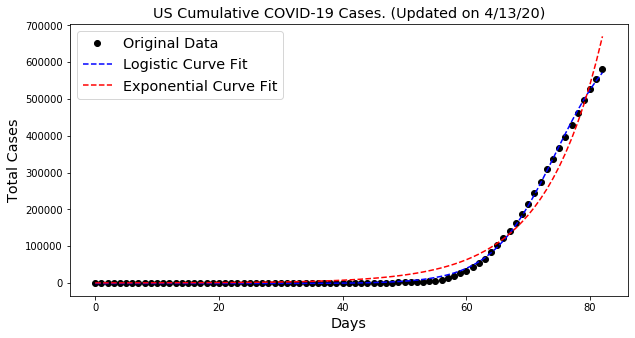



Spain

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 170099
	Confirmed cases on 4/6/20 	 136675
	Ratio: 1.24
	Weekly increase: 24.5 %
	Daily increase: 3.2 % per day
	Doubling Time (represents recent growth): 22.2 days

** Based on Logistic Fit**

	R^2: 0.9994035210535194
	Doubling Time (during middle of growth):  7.31 (± 0.2 ) days
	param:  [ 6.26329200e+04  1.89681125e-01 -6.44364076e+02  1.78761536e+05]

 exponential R^2  0.8969957953606795


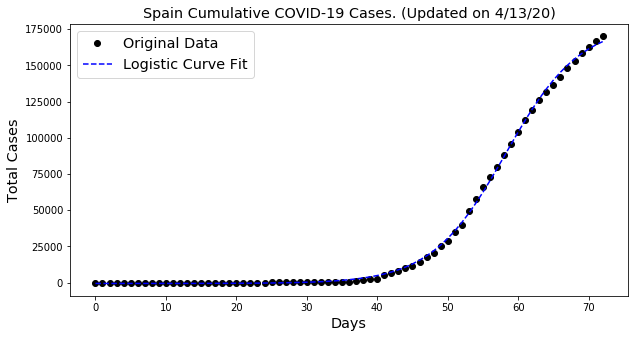



Italy

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 159516
	Confirmed cases on 4/6/20 	 132547
	Ratio: 1.2
	Weekly increase: 20.3 %
	Daily increase: 2.7 % per day
	Doubling Time (represents recent growth): 26.2 days

** Based on Logistic Fit**

	R^2: 0.9986080497314836
	Doubling Time (during middle of growth):  9.63 (± 0.4 ) days
	param:  [ 3.01134250e+03  1.43967933e-01 -1.32155282e+03  1.66066267e+05]

 exponential R^2  0.7938522817029051


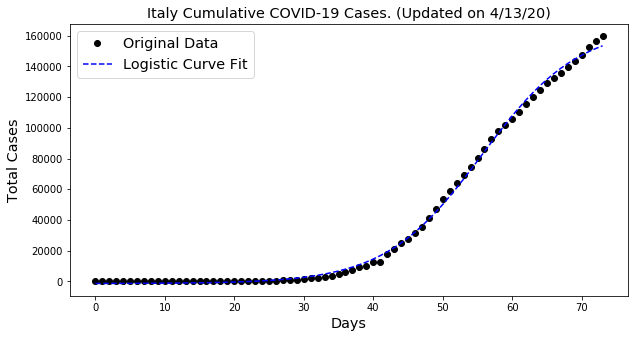



France

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 137875
	Confirmed cases on 4/6/20 	 98963
	Ratio: 1.39
	Weekly increase: 39.3 %
	Daily increase: 4.9 % per day
	Doubling Time (represents recent growth): 14.6 days

** Based on Logistic Fit**

	R^2: 0.997149793169751
	Doubling Time (during middle of growth):  8.07 (± 0.48 ) days
	param:  [2.21544620e+05 1.71848918e-01 2.61004387e+01 1.74277859e+05]

** Based on Exponential Fit **

	R^2: 0.9770977237179997
	Doubling Time (represents overall growth):  7.5 (± 0.56 ) days
	param:  [ 1.00000000e+02  9.24251592e-02 -1.00000000e+02]


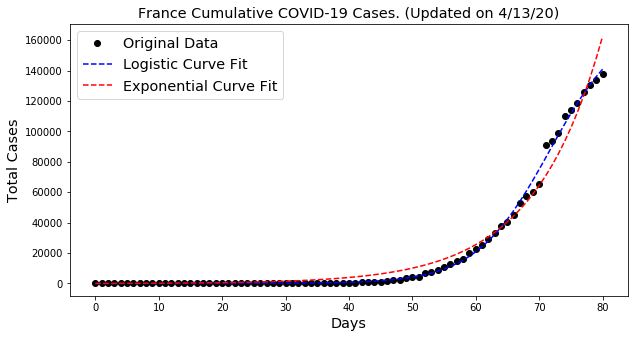



Germany

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 130072
	Confirmed cases on 4/6/20 	 103374
	Ratio: 1.26
	Weekly increase: 25.8 %
	Daily increase: 3.3 % per day
	Doubling Time (represents recent growth): 21.1 days

** Based on Logistic Fit**

	R^2: 0.999237302049304
	Doubling Time (during middle of growth):  7.76 (± 0.23 ) days
	param:  [ 8.41241490e+04  1.78618493e-01 -5.18734096e+02  1.39720215e+05]

 exponential R^2  0.9288851648540474


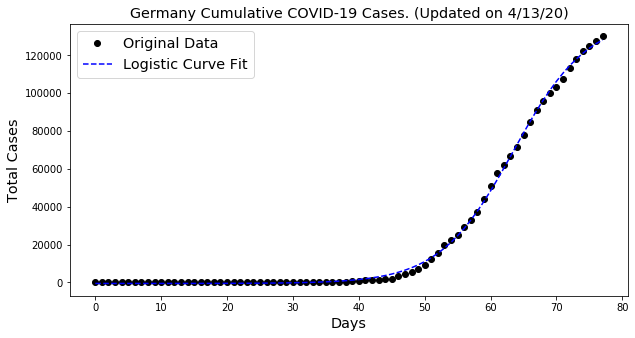



United Kingdom

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 89570
	Confirmed cases on 4/6/20 	 52279
	Ratio: 1.71
	Weekly increase: 71.3 %
	Daily increase: 8.0 % per day
	Doubling Time (represents recent growth): 9.0 days

** Based on Logistic Fit**

	R^2: 0.9992725901119975
	Doubling Time (during middle of growth):  8.14 (± 0.27 ) days
	param:  [ 1.10251424e+05  1.70392196e-01 -2.32055386e+02  1.28052523e+05]

** Based on Exponential Fit **

	R^2: 0.988265404699553
	Doubling Time (represents overall growth):  6.57 (± 0.36 ) days
	param:  [  44.350249      0.10558044 -100.        ]


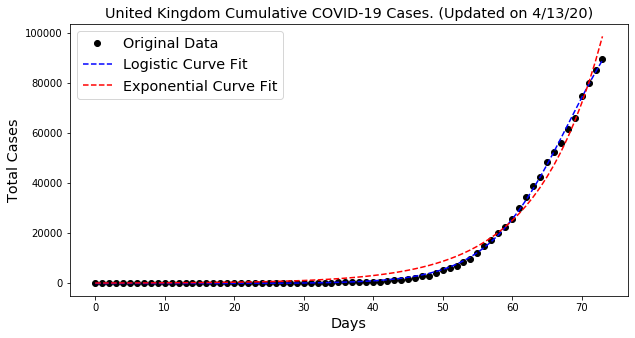



China

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 83213
	Confirmed cases on 4/6/20 	 82665
	Ratio: 1.01
	Weekly increase: 0.7 %
	Daily increase: 0.1 % per day
	Doubling Time (represents recent growth): 734.3 days

** Based on Logistic Fit**

	R^2: 0.9958211353556558
	Doubling Time (during middle of growth):  6.65 (± 0.45 ) days
	param:  [ 3.92293546e+01  2.08568643e-01 -1.76906016e+03  8.17127853e+04]

 exponential R^2  -2.730008048685396


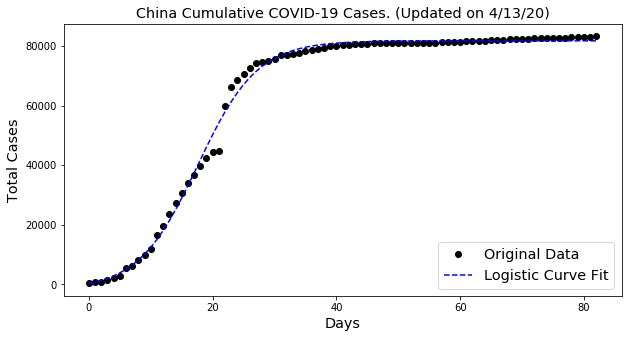



Iran

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 73303
	Confirmed cases on 4/6/20 	 60500
	Ratio: 1.21
	Weekly increase: 21.2 %
	Daily increase: 2.8 % per day
	Doubling Time (represents recent growth): 25.3 days

** Based on Logistic Fit**

	R^2: 0.9977772605332779
	Doubling Time (during middle of growth):  13.36 (± 1.09 ) days
	param:  [ 8.35488447e+01  1.03750279e-01 -1.55637888e+03  9.80589241e+04]

 exponential R^2  0.6599480048234123


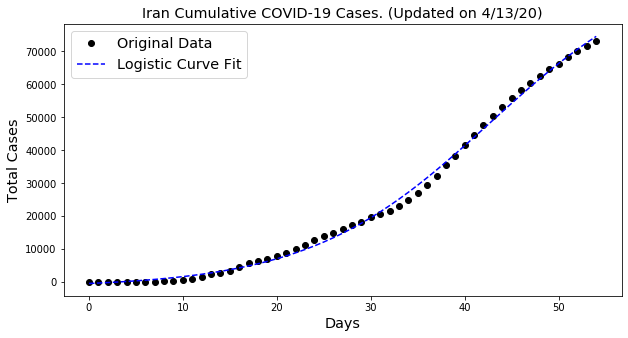



Turkey

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 61049
	Confirmed cases on 4/6/20 	 30217
	Ratio: 2.02
	Weekly increase: 102.0 %
	Daily increase: 10.6 % per day
	Doubling Time (represents recent growth): 6.9 days

** Based on Logistic Fit**

	R^2: 0.9987267750012411
	Doubling Time (during middle of growth):  7.77 (± 0.63 ) days
	param:  [ 2.19449269e+02  1.78326192e-01 -1.35898797e+03  9.85832385e+04]

 exponential R^2  0.8798950124886349


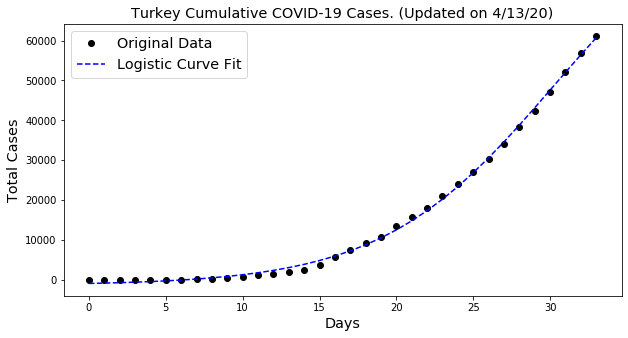



Belgium

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 30589
	Confirmed cases on 4/6/20 	 20814
	Ratio: 1.47
	Weekly increase: 47.0 %
	Daily increase: 5.7 % per day
	Doubling Time (represents recent growth): 12.6 days

** Based on Logistic Fit**

	R^2: 0.9986077160263119
	Doubling Time (during middle of growth):  8.08 (± 0.36 ) days
	param:  [ 2.87258450e+04  1.71675103e-01 -1.18333096e+02  3.60910377e+04]

** Based on Exponential Fit **

	R^2: 0.9766480108516699
	Doubling Time (represents overall growth):  7.89 (± 0.67 ) days
	param:  [ 8.08403572e+01  8.78687961e-02 -1.00000000e+02]


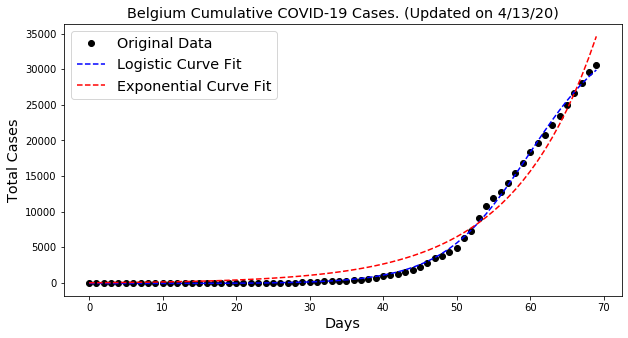



Netherlands

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 26710
	Confirmed cases on 4/6/20 	 18926
	Ratio: 1.41
	Weekly increase: 41.1 %
	Daily increase: 5.0 % per day
	Doubling Time (represents recent growth): 14.1 days

** Based on Logistic Fit**

	R^2: 0.9982286611966004
	Doubling Time (during middle of growth):  9.63 (± 0.68 ) days
	param:  [ 1.79809368e+02  1.44019798e-01 -5.22067512e+02  3.22621214e+04]

 exponential R^2  0.8540848865953543


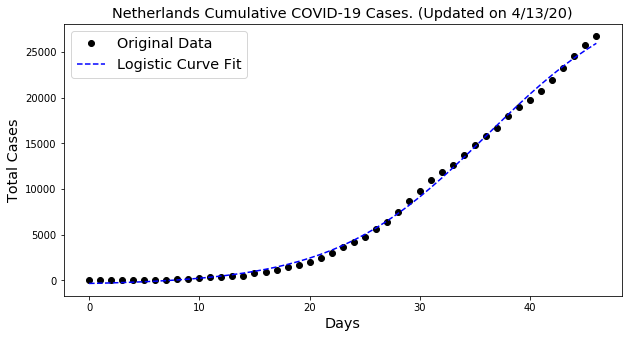



Switzerland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 25688
	Confirmed cases on 4/6/20 	 21657
	Ratio: 1.19
	Weekly increase: 18.6 %
	Daily increase: 2.5 % per day
	Doubling Time (represents recent growth): 28.4 days

** Based on Logistic Fit**

	R^2: 0.9979677954880922
	Doubling Time (during middle of growth):  8.04 (± 0.51 ) days
	param:  [ 2.27987895e+02  1.72367312e-01 -5.10107573e+02  2.66860741e+04]

 exponential R^2  0.6969670358041593


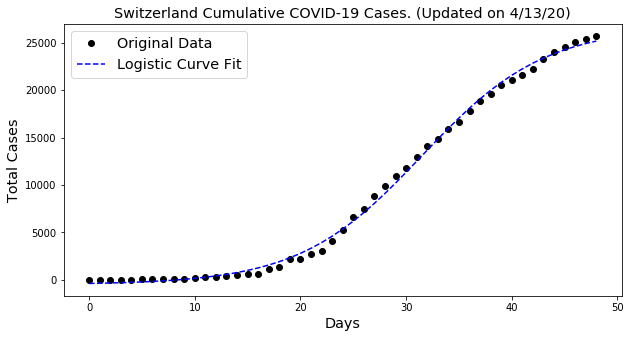



Canada

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 25679
	Confirmed cases on 4/6/20 	 16563
	Ratio: 1.55
	Weekly increase: 55.0 %
	Daily increase: 6.5 % per day
	Doubling Time (represents recent growth): 11.1 days

** Based on Logistic Fit**

	R^2: 0.9993056045658482
	Doubling Time (during middle of growth):  7.25 (± 0.22 ) days
	param:  [ 6.75157687e+05  1.91282512e-01 -5.12402125e+01  3.09252489e+04]

** Based on Exponential Fit **

	R^2: 0.980086960647138
	Doubling Time (represents overall growth):  7.01 (± 0.49 ) days
	param:  [ 1.29646849e+01  9.89099894e-02 -1.00000000e+02]


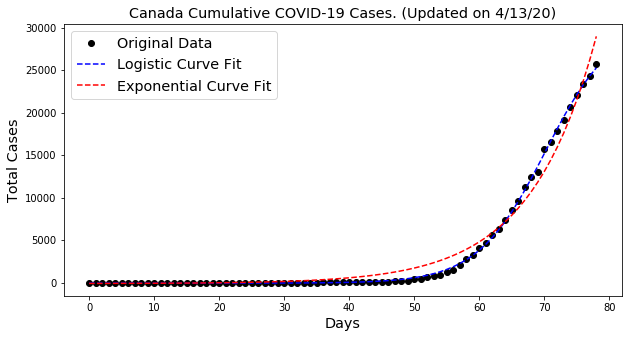



Brazil

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 23430
	Confirmed cases on 4/6/20 	 12161
	Ratio: 1.93
	Weekly increase: 92.7 %
	Daily increase: 9.8 % per day
	Doubling Time (represents recent growth): 7.4 days

** Based on Logistic Fit**

	R^2: 0.9987548382701218
	Doubling Time (during middle of growth):  8.07 (± 0.47 ) days
	param:  [ 1.79068848e+03  1.71831573e-01 -1.10071384e+02  3.70436854e+04]

** Based on Exponential Fit **

	R^2: 0.9872302083868304
	Doubling Time (represents overall growth):  5.84 (± 0.45 ) days
	param:  [ 100.            0.11876975 -100.        ]


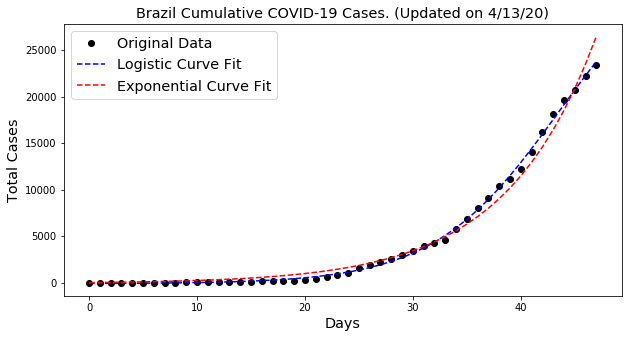



Russia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 18328
	Confirmed cases on 4/6/20 	 6343
	Ratio: 2.89
	Weekly increase: 188.9 %
	Daily increase: 16.4 % per day
	Doubling Time (represents recent growth): 4.6 days

Exception in logstic process 
<class 'RuntimeError'>
Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

** Based on Exponential Fit **

	R^2: 0.9989416700605229
	Doubling Time (represents overall growth):  4.48 (± 0.07 ) days
	param:  [  0.23193421   0.15472045 -66.80534636]


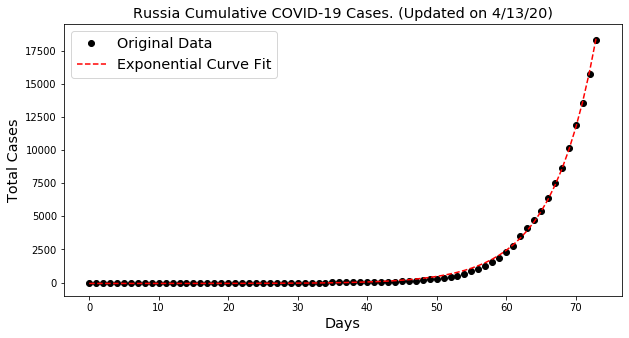



Portugal

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 16934
	Confirmed cases on 4/6/20 	 11730
	Ratio: 1.44
	Weekly increase: 44.4 %
	Daily increase: 5.4 % per day
	Doubling Time (represents recent growth): 13.2 days

** Based on Logistic Fit**

	R^2: 0.9976817623547921
	Doubling Time (during middle of growth):  7.87 (± 0.62 ) days
	param:  [ 2.80973657e+02  1.76103535e-01 -3.01841660e+02  1.96268468e+04]

 exponential R^2  0.890873174489644


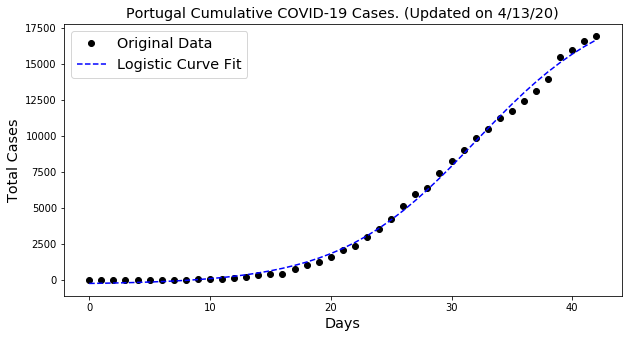



Austria

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 14041
	Confirmed cases on 4/6/20 	 12297
	Ratio: 1.14
	Weekly increase: 14.2 %
	Daily increase: 1.9 % per day
	Doubling Time (represents recent growth): 36.6 days

** Based on Logistic Fit**

	R^2: 0.9988110750186909
	Doubling Time (during middle of growth):  6.26 (± 0.29 ) days
	param:  [ 8.57656153e+02  2.21539205e-01 -1.15474283e+02  1.39332339e+04]

 exponential R^2  0.7438866694264259


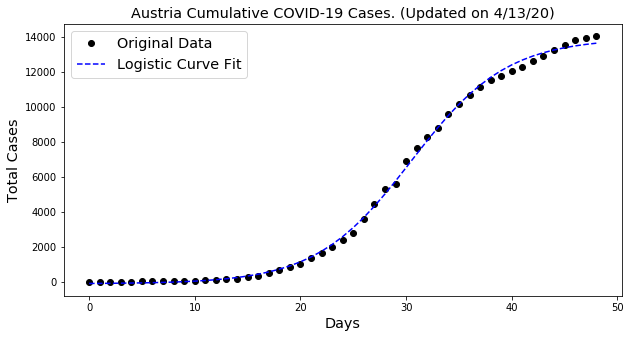



Israel

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 11586
	Confirmed cases on 4/6/20 	 8904
	Ratio: 1.3
	Weekly increase: 30.1 %
	Daily increase: 3.8 % per day
	Doubling Time (represents recent growth): 18.4 days

** Based on Logistic Fit**

	R^2: 0.9982135879727697
	Doubling Time (during middle of growth):  6.13 (± 0.34 ) days
	param:  [ 8.16304793e+03  2.26244211e-01 -4.65835754e+01  1.18032180e+04]

 exponential R^2  0.9427450147295645


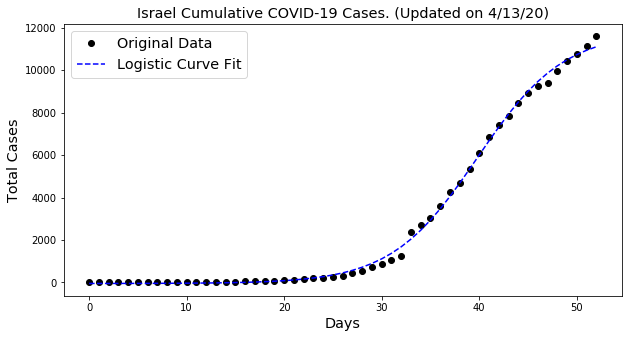



Sweden

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 10948
	Confirmed cases on 4/6/20 	 7206
	Ratio: 1.52
	Weekly increase: 51.9 %
	Daily increase: 6.2 % per day
	Doubling Time (represents recent growth): 11.6 days

** Based on Logistic Fit**

	R^2: 0.9988980244233183
	Doubling Time (during middle of growth):  11.83 (± 0.52 ) days
	param:  [ 3.32342567e+03  1.17165614e-01 -6.23771812e+01  1.82163322e+04]

** Based on Exponential Fit **

	R^2: 0.9916966239130849
	Doubling Time (represents overall growth):  8.84 (± 0.43 ) days
	param:  [ 3.95462739e+01  7.84275361e-02 -1.00000000e+02]


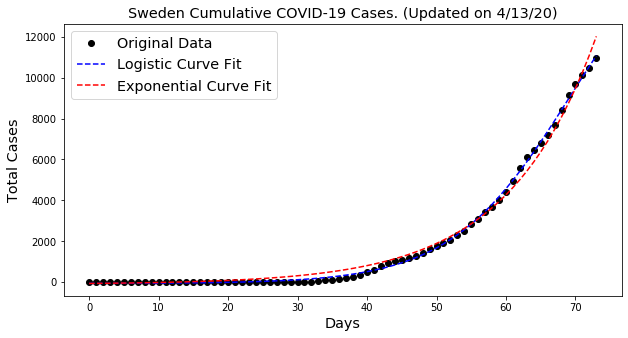



Ireland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 10647
	Confirmed cases on 4/6/20 	 5364
	Ratio: 1.98
	Weekly increase: 98.5 %
	Daily increase: 10.3 % per day
	Doubling Time (represents recent growth): 7.1 days

** Based on Logistic Fit**

	R^2: 0.9948971599844432
	Doubling Time (during middle of growth):  14.92 (± 3.21 ) days
	param:  [ 1.11811007e+03  9.29111075e-02 -4.12487323e+02  2.15118788e+05]

** Based on Exponential Fit **

	R^2: 0.9900031573010076
	Doubling Time (represents overall growth):  6.48 (± 0.48 ) days
	param:  [100.           0.10696253 -59.4328811 ]


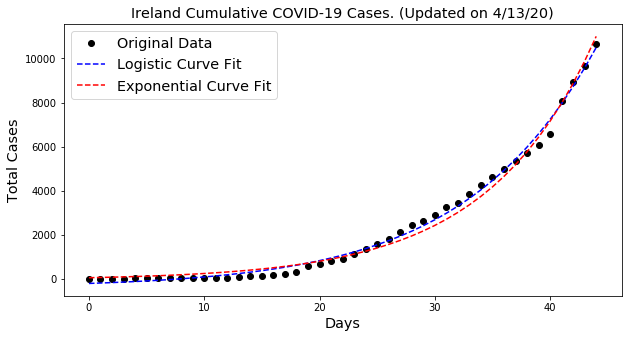



Korea, South

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 10537
	Confirmed cases on 4/6/20 	 10284
	Ratio: 1.02
	Weekly increase: 2.5 %
	Daily increase: 0.3 % per day
	Doubling Time (represents recent growth): 199.6 days

** Based on Logistic Fit**

	R^2: 0.9897414602597072
	Doubling Time (during middle of growth):  6.82 (± 0.74 ) days
	param:  [ 4.69104290e+03  2.03129272e-01 -1.65986744e+02  9.72967860e+03]

 exponential R^2  0.5115976954319517


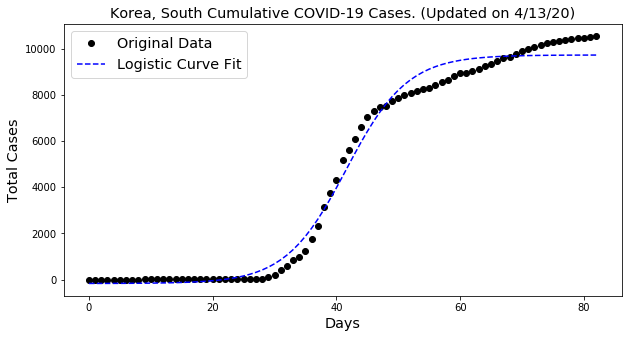



India

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 10453
	Confirmed cases on 4/6/20 	 4778
	Ratio: 2.19
	Weekly increase: 118.8 %
	Daily increase: 11.8 % per day
	Doubling Time (represents recent growth): 6.2 days

** Based on Logistic Fit**

	R^2: 0.9987272941646227
	Doubling Time (during middle of growth):  7.07 (± 0.32 ) days
	param:  [1.64255492e+06 1.96025740e-01 1.44944980e+01 1.88127614e+04]

** Based on Exponential Fit **

	R^2: 0.9946786867006502
	Doubling Time (represents overall growth):  5.11 (± 0.18 ) days
	param:  [  0.47769328   0.13573862 -55.07145149]


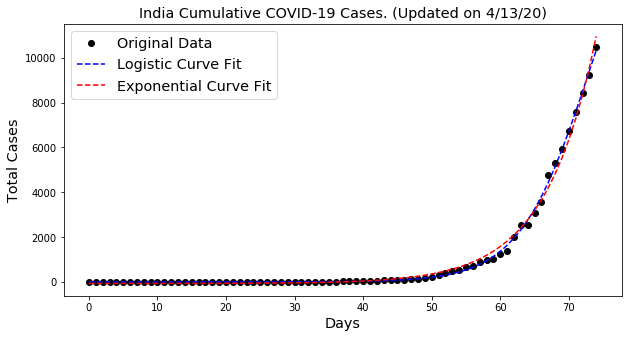



Peru

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 9784
	Confirmed cases on 4/6/20 	 2561
	Ratio: 3.82
	Weekly increase: 282.0 %
	Daily increase: 21.1 % per day
	Doubling Time (represents recent growth): 3.6 days

** Based on Logistic Fit**

	R^2: 0.994405549632046
	Doubling Time (during middle of growth):  7.92 (± 1.33 ) days
	param:  [1.10584980e+09 1.74975697e-01 4.77408451e+01 1.36628819e+10]

** Based on Exponential Fit **

	R^2: 0.9944055499017943
	Doubling Time (represents overall growth):  3.96 (± 0.21 ) days
	param:  [12.35512156  0.17497563 47.74069582]


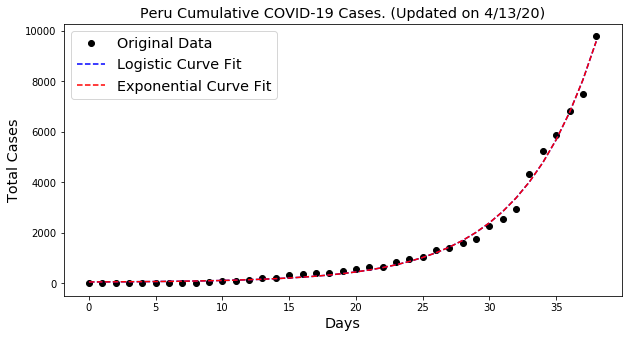



Ecuador

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 7529
	Confirmed cases on 4/6/20 	 3747
	Ratio: 2.01
	Weekly increase: 100.9 %
	Daily increase: 10.5 % per day
	Doubling Time (represents recent growth): 7.0 days

** Based on Logistic Fit**

	R^2: 0.9807897977723851
	Doubling Time (during middle of growth):  13.51 (± 5.22 ) days
	param:  [ 3.81575593e+02  1.02603020e-01 -2.81445224e+02  4.61492527e+04]

** Based on Exponential Fit **

	R^2: 0.9777857300152846
	Doubling Time (represents overall growth):  6.73 (± 0.78 ) days
	param:  [ 100.            0.10301899 -100.        ]


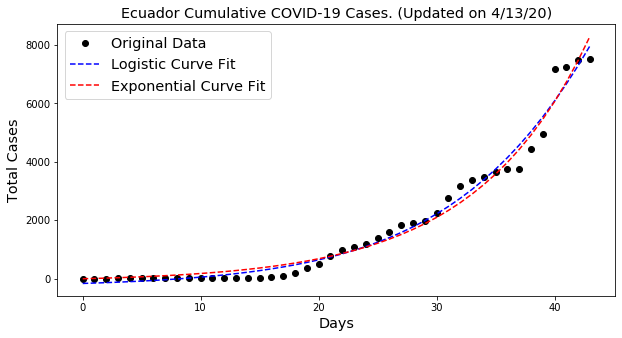



Chile

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 7525
	Confirmed cases on 4/6/20 	 4815
	Ratio: 1.56
	Weekly increase: 56.3 %
	Daily increase: 6.6 % per day
	Doubling Time (represents recent growth): 10.9 days

** Based on Logistic Fit**

	R^2: 0.9989164955574488
	Doubling Time (during middle of growth):  8.71 (± 0.53 ) days
	param:  [ 2.28198914e+02  1.59204279e-01 -1.39509836e+02  1.00166134e+04]

** Based on Exponential Fit **

	R^2: 0.9659925328666176
	Doubling Time (represents overall growth):  6.35 (± 0.94 ) days
	param:  [100.           0.10914932  48.42461498]


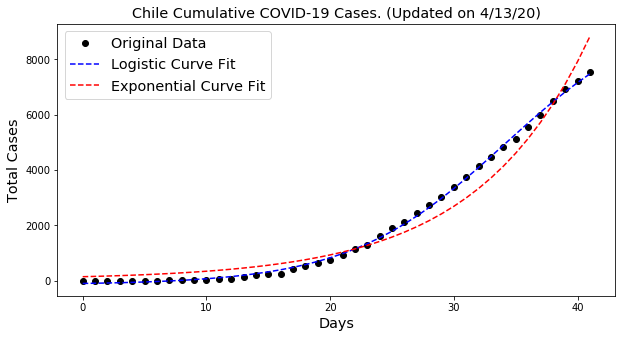



Japan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 7370
	Confirmed cases on 4/6/20 	 3654
	Ratio: 2.02
	Weekly increase: 101.7 %
	Daily increase: 10.5 % per day
	Doubling Time (represents recent growth): 6.9 days

** Based on Logistic Fit**

	R^2: 0.9934254838562444
	Doubling Time (during middle of growth):  14.82 (± 0.57 ) days
	param:  [3.10074552e+11 9.35326579e-02 9.02774733e+01 1.01678377e+12]

** Based on Exponential Fit **

	R^2: 0.9934254839325802
	Doubling Time (represents overall growth):  7.41 (± 0.28 ) days
	param:  [ 3.2791963   0.09353251 90.2765054 ]


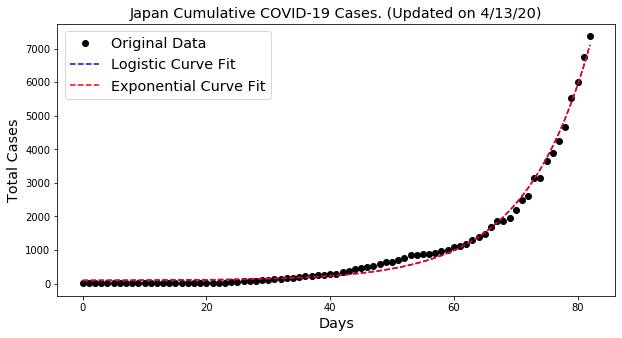



Poland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 6934
	Confirmed cases on 4/6/20 	 4413
	Ratio: 1.57
	Weekly increase: 57.1 %
	Daily increase: 6.7 % per day
	Doubling Time (represents recent growth): 10.7 days

** Based on Logistic Fit**

	R^2: 0.9997586174552172
	Doubling Time (during middle of growth):  8.67 (± 0.26 ) days
	param:  [ 2.23252574e+02  1.59837828e-01 -8.45749568e+01  9.60533000e+03]

** Based on Exponential Fit **

	R^2: 0.9712692872460693
	Doubling Time (represents overall growth):  6.32 (± 0.87 ) days
	param:  [100.           0.10976187  49.92306897]


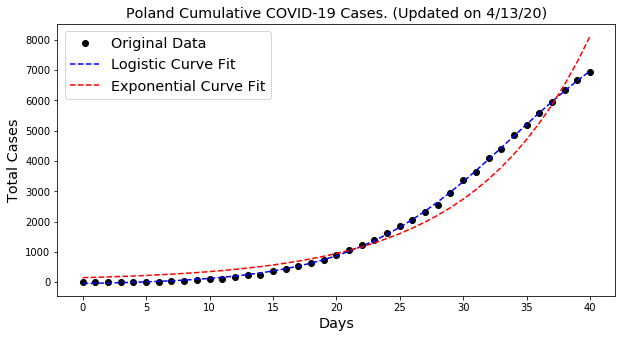



Romania

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 6633
	Confirmed cases on 4/6/20 	 4057
	Ratio: 1.63
	Weekly increase: 63.5 %
	Daily increase: 7.3 % per day
	Doubling Time (represents recent growth): 9.9 days

** Based on Logistic Fit**

	R^2: 0.9986699630879874
	Doubling Time (during middle of growth):  8.36 (± 0.49 ) days
	param:  [ 8.27696158e+02  1.65881790e-01 -5.71594772e+01  8.76682866e+03]

** Based on Exponential Fit **

	R^2: 0.9837926649728715
	Doubling Time (represents overall growth):  7.34 (± 0.7 ) days
	param:  [ 8.77327297e+01  9.43800744e-02 -1.00000000e+02]


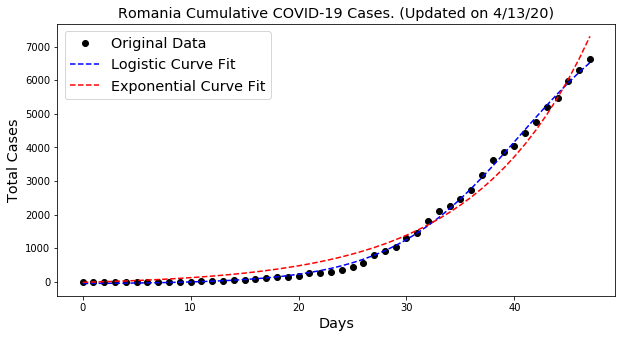



Norway

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 6603
	Confirmed cases on 4/6/20 	 5865
	Ratio: 1.13
	Weekly increase: 12.6 %
	Daily increase: 1.7 % per day
	Doubling Time (represents recent growth): 40.9 days

** Based on Logistic Fit**

	R^2: 0.9988933843282487
	Doubling Time (during middle of growth):  9.84 (± 0.51 ) days
	param:  [ 6.06573035e+01  1.40853352e-01 -2.07477962e+02  7.15564242e+03]

 exponential R^2  0.7636145805322837


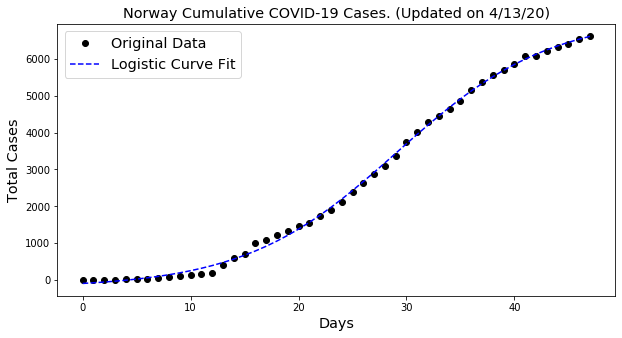



Denmark

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 6513
	Confirmed cases on 4/6/20 	 4875
	Ratio: 1.34
	Weekly increase: 33.6 %
	Daily increase: 4.2 % per day
	Doubling Time (represents recent growth): 16.7 days

** Based on Logistic Fit**

	R^2: 0.9954975290360781
	Doubling Time (during middle of growth):  14.33 (± 2.32 ) days
	param:  [ 6.07546449e+01  9.67225718e-02 -2.53597723e+02  1.17781356e+04]

 exponential R^2  0.9413640750611548


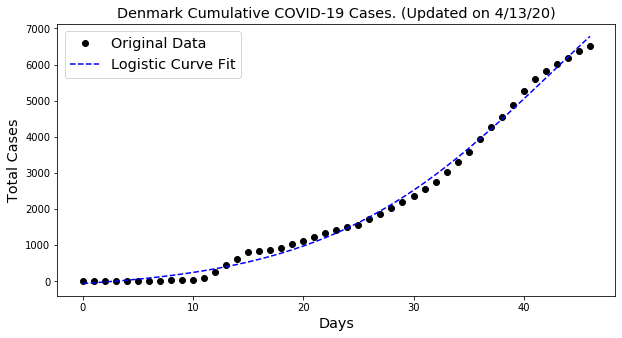



Australia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 6351
	Confirmed cases on 4/6/20 	 5797
	Ratio: 1.1
	Weekly increase: 9.6 %
	Daily increase: 1.3 % per day
	Doubling Time (represents recent growth): 53.2 days

** Based on Logistic Fit**

	R^2: 0.9996519646036017
	Doubling Time (during middle of growth):  5.58 (± 0.11 ) days
	param:  [3.90767479e+06 2.48387232e-01 1.03146568e+01 6.36582710e+03]

 exponential R^2  0.9277668771437274


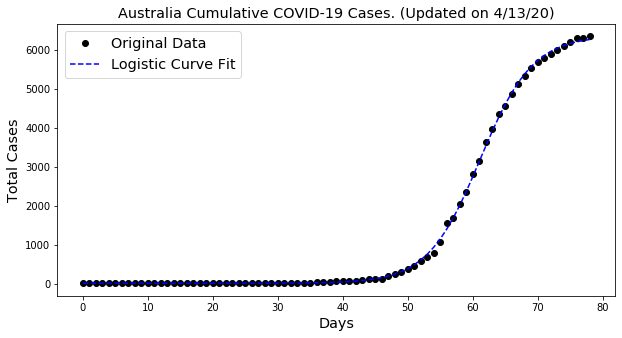



Czechia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 6059
	Confirmed cases on 4/6/20 	 4822
	Ratio: 1.26
	Weekly increase: 25.7 %
	Daily increase: 3.3 % per day
	Doubling Time (represents recent growth): 21.2 days

** Based on Logistic Fit**

	R^2: 0.9991234014467605
	Doubling Time (during middle of growth):  8.15 (± 0.38 ) days
	param:  [ 1.66740399e+02  1.70177157e-01 -1.09118320e+02  6.73624773e+03]

 exponential R^2  0.8991963822915487


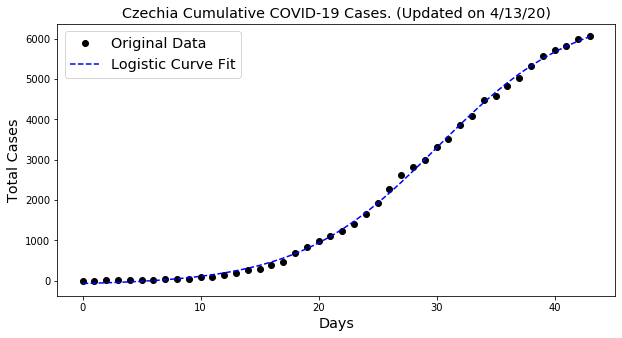



Pakistan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 5496
	Confirmed cases on 4/6/20 	 3766
	Ratio: 1.46
	Weekly increase: 45.9 %
	Daily increase: 5.5 % per day
	Doubling Time (represents recent growth): 12.8 days

** Based on Logistic Fit**

	R^2: 0.997099016221874
	Doubling Time (during middle of growth):  9.98 (± 0.95 ) days
	param:  [ 3.33454407e+02  1.38887444e-01 -8.56814466e+01  8.28432532e+03]

** Based on Exponential Fit **

	R^2: 0.9848161128280214
	Doubling Time (represents overall growth):  7.89 (± 0.75 ) days
	param:  [ 1.00000000e+02  8.78593077e-02 -1.00000000e+02]


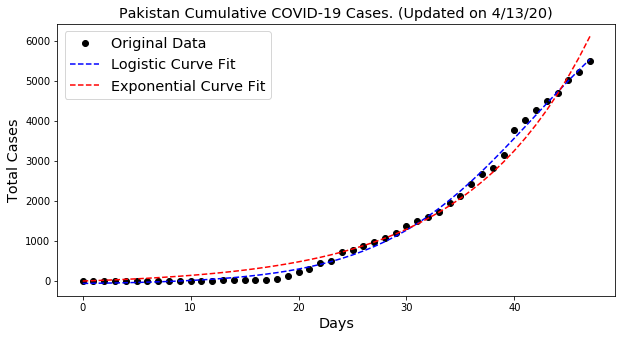



Saudi Arabia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 4934
	Confirmed cases on 4/6/20 	 2605
	Ratio: 1.89
	Weekly increase: 89.4 %
	Daily increase: 9.6 % per day
	Doubling Time (represents recent growth): 7.6 days

** Based on Logistic Fit**

	R^2: 0.9961293102279525
	Doubling Time (during middle of growth):  16.6 (± 3.76 ) days
	param:  [ 7.90290383e+02  8.35334785e-02 -2.71587171e+02  1.25089959e+05]

** Based on Exponential Fit **

	R^2: 0.9932973358960537
	Doubling Time (represents overall growth):  7.41 (± 0.5 ) days
	param:  [ 1.00000000e+02  9.34909352e-02 -1.00000000e+02]


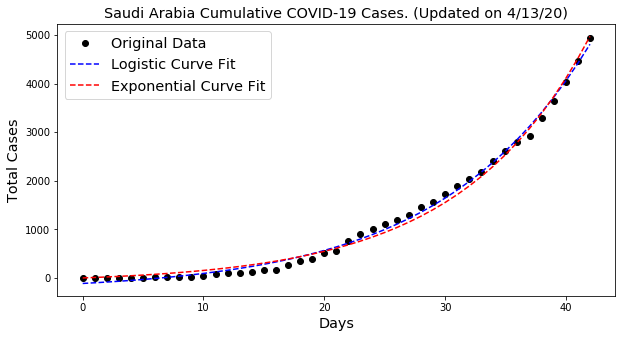



Philippines

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 4932
	Confirmed cases on 4/6/20 	 3660
	Ratio: 1.35
	Weekly increase: 34.8 %
	Daily increase: 4.4 % per day
	Doubling Time (represents recent growth): 16.3 days

** Based on Logistic Fit**

	R^2: 0.997636786431775
	Doubling Time (during middle of growth):  5.91 (± 0.32 ) days
	param:  [2.60021308e+06 2.34376504e-01 6.06890438e+00 5.02065211e+03]

** Based on Exponential Fit **

	R^2: 0.9653971425888981
	Doubling Time (represents overall growth):  7.96 (± 0.77 ) days
	param:  [ 9.04757979e+00  8.71214470e-02 -1.00000000e+02]


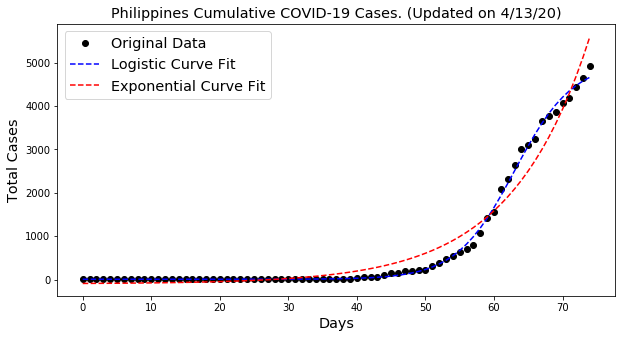



Malaysia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 4817
	Confirmed cases on 4/6/20 	 3793
	Ratio: 1.27
	Weekly increase: 27.0 %
	Daily increase: 3.5 % per day
	Doubling Time (represents recent growth): 20.3 days

** Based on Logistic Fit**

	R^2: 0.9977956267624344
	Doubling Time (during middle of growth):  9.36 (± 0.48 ) days
	param:  [ 1.48116106e+04  1.48184800e-01 -2.00029096e+01  5.21957139e+03]

** Based on Exponential Fit **

	R^2: 0.969003167871343
	Doubling Time (represents overall growth):  10.86 (± 1.05 ) days
	param:  [ 3.64444130e+01  6.38157537e-02 -1.00000000e+02]


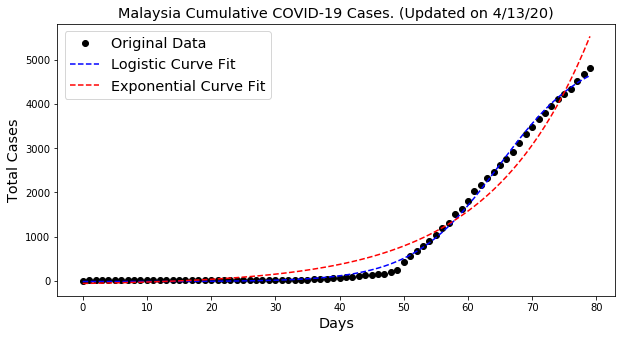



Mexico

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 4661
	Confirmed cases on 4/6/20 	 2143
	Ratio: 2.17
	Weekly increase: 117.5 %
	Daily increase: 11.7 % per day
	Doubling Time (represents recent growth): 6.2 days

** Based on Logistic Fit**

	R^2: 0.9991253346979204
	Doubling Time (during middle of growth):  9.85 (± 0.59 ) days
	param:  [ 1.02773065e+03  1.40673934e-01 -4.72504506e+01  1.32503358e+04]

** Based on Exponential Fit **

	R^2: 0.9978933038541382
	Doubling Time (represents overall growth):  6.2 (± 0.2 ) days
	param:  [  32.09245942    0.11172813 -100.        ]


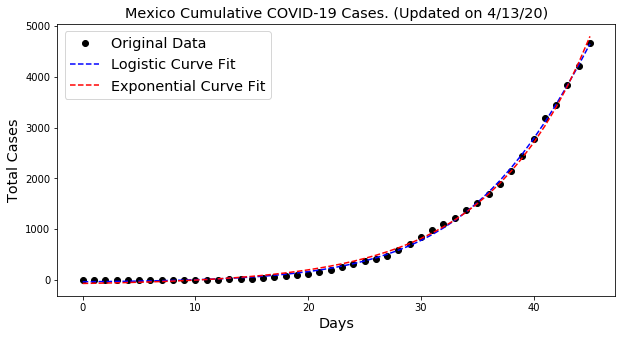



Indonesia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 4557
	Confirmed cases on 4/6/20 	 2491
	Ratio: 1.83
	Weekly increase: 82.9 %
	Daily increase: 9.0 % per day
	Doubling Time (represents recent growth): 8.0 days

** Based on Logistic Fit**

	R^2: 0.99808997524254
	Doubling Time (during middle of growth):  14.5 (± 1.91 ) days
	param:  [ 1.61697791e+02  9.56321933e-02 -2.01823677e+02  1.82191825e+04]

** Based on Exponential Fit **

	R^2: 0.9941516188774872
	Doubling Time (represents overall growth):  7.5 (± 0.47 ) days
	param:  [ 1.0000000e+02  9.2406928e-02 -1.0000000e+02]


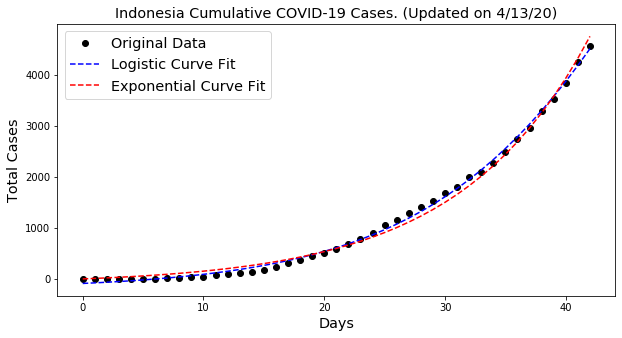



United Arab Emirates

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 4521
	Confirmed cases on 4/6/20 	 2076
	Ratio: 2.18
	Weekly increase: 117.8 %
	Daily increase: 11.8 % per day
	Doubling Time (represents recent growth): 6.2 days

Exception in logstic process 
<class 'RuntimeError'>
Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

** Based on Exponential Fit **

	R^2: 0.994641408177965
	Doubling Time (represents overall growth):  5.25 (± 0.18 ) days
	param:  [  0.24202083   0.13197298 -11.95741346]


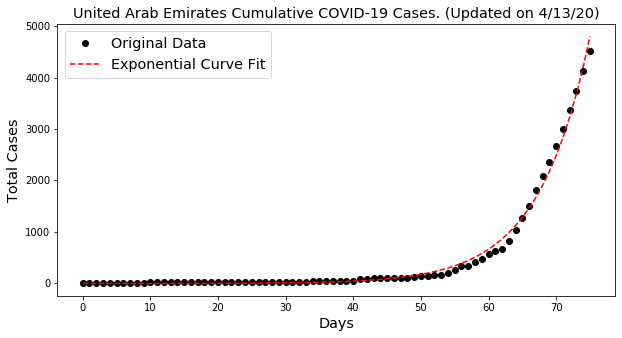



Serbia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 4054
	Confirmed cases on 4/6/20 	 2200
	Ratio: 1.84
	Weekly increase: 84.3 %
	Daily increase: 9.1 % per day
	Doubling Time (represents recent growth): 7.9 days

** Based on Logistic Fit**

	R^2: 0.998826543753643
	Doubling Time (during middle of growth):  7.86 (± 0.53 ) days
	param:  [ 4.41718473e+02  1.76337084e-01 -1.95878792e+01  6.10851268e+03]

** Based on Exponential Fit **

	R^2: 0.991654997037878
	Doubling Time (represents overall growth):  6.43 (± 0.5 ) days
	param:  [  72.85143479    0.10772518 -100.        ]


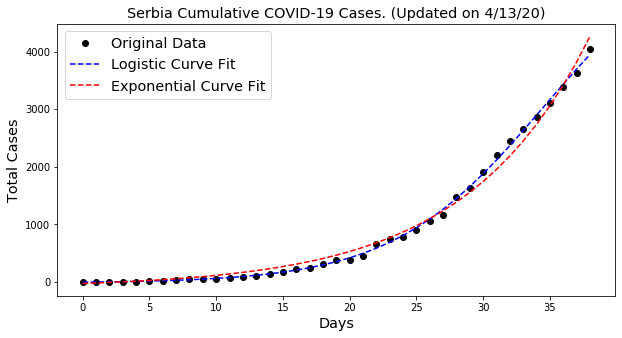



Panama

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 3400
	Confirmed cases on 4/6/20 	 1988
	Ratio: 1.71
	Weekly increase: 71.0 %
	Daily increase: 8.0 % per day
	Doubling Time (represents recent growth): 9.0 days

** Based on Logistic Fit**

	R^2: 0.9981065904745244
	Doubling Time (during middle of growth):  11.64 (± 1.6 ) days
	param:  [ 5.92157655e+01  1.19141553e-01 -1.74780029e+02  7.07541788e+03]

** Based on Exponential Fit **

	R^2: 0.9810643327119504
	Doubling Time (represents overall growth):  6.49 (± 0.86 ) days
	param:  [100.           0.10674339  -9.88096406]


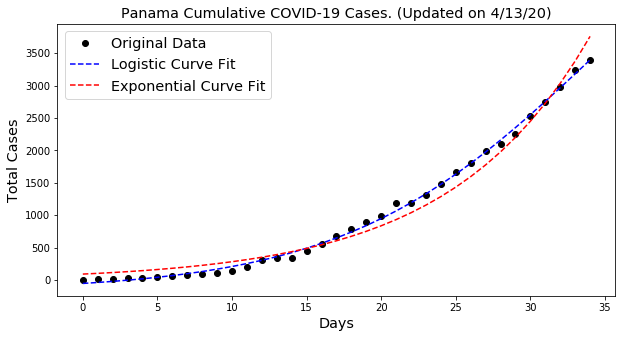



Luxembourg

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 3292
	Confirmed cases on 4/6/20 	 2843
	Ratio: 1.16
	Weekly increase: 15.8 %
	Daily increase: 2.1 % per day
	Doubling Time (represents recent growth): 33.1 days

** Based on Logistic Fit**

	R^2: 0.997160706085428
	Doubling Time (during middle of growth):  6.57 (± 0.5 ) days
	param:  [ 3.29820608e+02  2.10969588e-01 -7.37794098e+01  3.34166434e+03]

 exponential R^2  0.8766853009606084


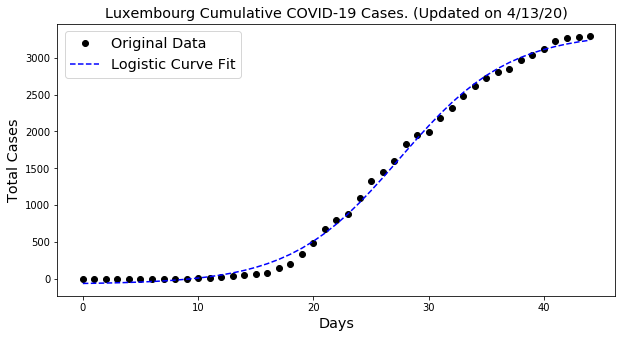



Qatar

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 3231
	Confirmed cases on 4/6/20 	 1832
	Ratio: 1.76
	Weekly increase: 76.4 %
	Daily increase: 8.4 % per day
	Doubling Time (represents recent growth): 8.6 days

** Based on Logistic Fit**

	R^2: 0.9799777254902774
	Doubling Time (during middle of growth):  14.02 (± 5.71 ) days
	param:  [6.12557573e+06 9.89011648e-02 3.01031750e+01 2.60598745e+08]

** Based on Exponential Fit **

	R^2: 0.9799777264096818
	Doubling Time (represents overall growth):  7.01 (± 0.76 ) days
	param:  [42.54383265  0.09890037 30.10100385]


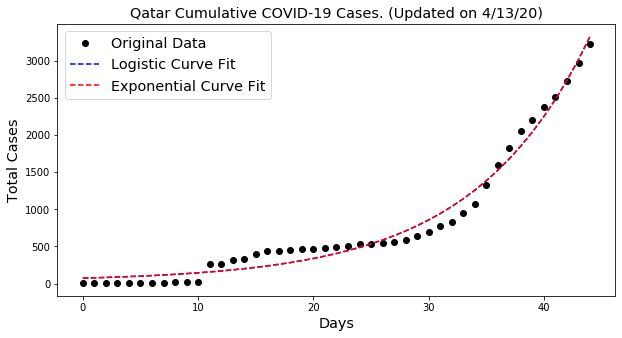



Dominican Republic

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 3167
	Confirmed cases on 4/6/20 	 1828
	Ratio: 1.73
	Weekly increase: 73.2 %
	Daily increase: 8.2 % per day
	Doubling Time (represents recent growth): 8.8 days

** Based on Logistic Fit**

	R^2: 0.9948031217067502
	Doubling Time (during middle of growth):  9.01 (± 1.19 ) days
	param:  [ 3.30058693e+02  1.53814973e-01 -6.97258458e+01  4.46765715e+03]

** Based on Exponential Fit **

	R^2: 0.9837983806459523
	Doubling Time (represents overall growth):  7.45 (± 0.78 ) days
	param:  [ 6.42047438e+01  9.29865145e-02 -1.00000000e+02]


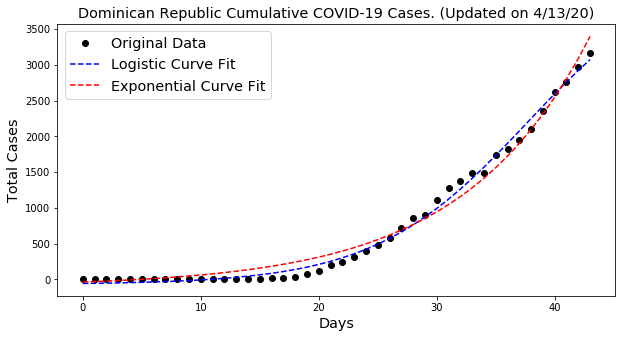



Ukraine

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 3102
	Confirmed cases on 4/6/20 	 1319
	Ratio: 2.35
	Weekly increase: 135.2 %
	Daily increase: 13.0 % per day
	Doubling Time (represents recent growth): 5.7 days

** Based on Logistic Fit**

	R^2: 0.9943537289161611
	Doubling Time (during middle of growth):  9.44 (± 1.55 ) days
	param:  [ 7.30977310e+02  1.46776520e-01 -5.75447399e+01  8.57048434e+03]

** Based on Exponential Fit **

	R^2: 0.9930989545962318
	Doubling Time (represents overall growth):  6.0 (± 0.38 ) days
	param:  [  28.43903815    0.11554181 -100.        ]


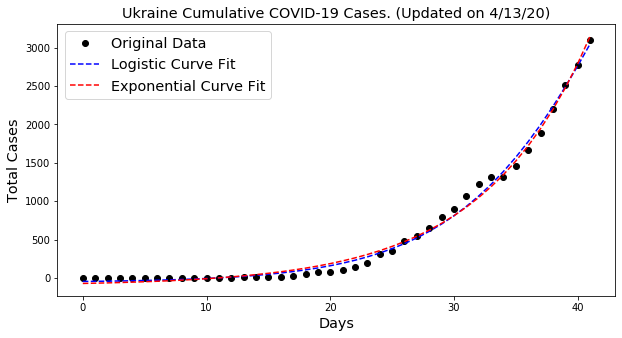



Finland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 3064
	Confirmed cases on 4/6/20 	 2176
	Ratio: 1.41
	Weekly increase: 40.8 %
	Daily increase: 5.0 % per day
	Doubling Time (represents recent growth): 14.2 days

** Based on Logistic Fit**

	R^2: 0.9968163085920013
	Doubling Time (during middle of growth):  11.34 (± 0.8 ) days
	param:  [ 4.18027141e+03  1.22229161e-01 -2.69587620e+01  4.44523972e+03]

** Based on Exponential Fit **

	R^2: 0.9875083440154487
	Doubling Time (represents overall growth):  9.79 (± 0.59 ) days
	param:  [ 1.72169235e+01  7.08350109e-02 -1.00000000e+02]


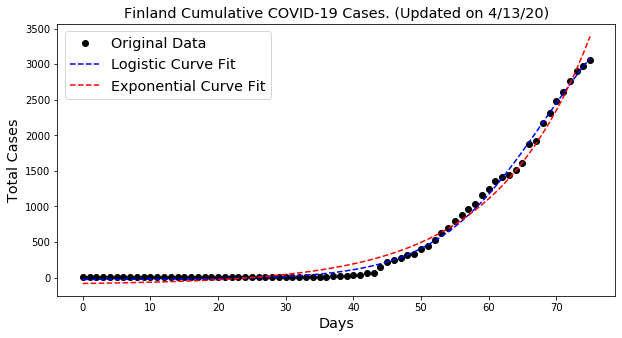



Belarus

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 2919
	Confirmed cases on 4/6/20 	 700
	Ratio: 4.17
	Weekly increase: 317.0 %
	Daily increase: 22.6 % per day
	Doubling Time (represents recent growth): 3.4 days

** Based on Logistic Fit**

	R^2: 0.9968849933916103
	Doubling Time (during middle of growth):  4.27 (± 0.39 ) days
	param:  [1.30883227e+06 3.24366405e-01 3.23613141e+01 4.70099094e+03]

** Based on Exponential Fit **

	R^2: 0.9909089239202084
	Doubling Time (represents overall growth):  3.42 (± 0.2 ) days
	param:  [0.33809512 0.20289952 2.34485918]


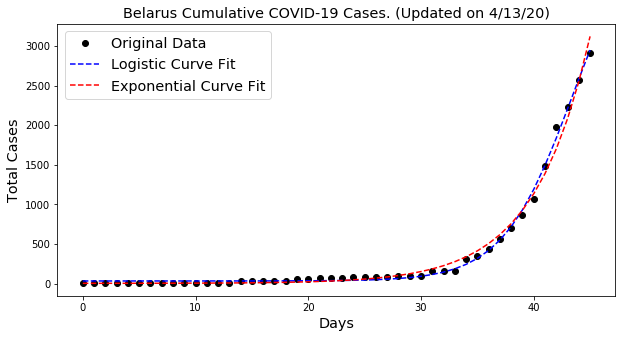



Singapore

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 2918
	Confirmed cases on 4/6/20 	 1375
	Ratio: 2.12
	Weekly increase: 112.2 %
	Daily increase: 11.3 % per day
	Doubling Time (represents recent growth): 6.4 days

** Based on Logistic Fit**

	R^2: 0.9945060722363711
	Doubling Time (during middle of growth):  15.94 (± 0.66 ) days
	param:  [3.99397508e+10 8.69959386e-02 3.33787899e+01 9.36025429e+10]

** Based on Exponential Fit **

	R^2: 0.9945060724507423
	Doubling Time (represents overall growth):  7.97 (± 0.28 ) days
	param:  [ 2.34360565  0.08699587 33.37858252]


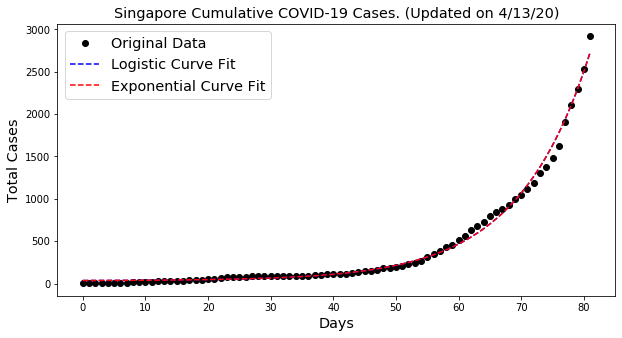



Colombia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 2852
	Confirmed cases on 4/6/20 	 1579
	Ratio: 1.81
	Weekly increase: 80.6 %
	Daily increase: 8.8 % per day
	Doubling Time (represents recent growth): 8.2 days

** Based on Logistic Fit**

	R^2: 0.9973486916517784
	Doubling Time (during middle of growth):  10.23 (± 1.24 ) days
	param:  [ 1.36132675e+02  1.35573609e-01 -7.52170462e+01  5.32624360e+03]

** Based on Exponential Fit **

	R^2: 0.9908715850430394
	Doubling Time (represents overall growth):  7.44 (± 0.66 ) days
	param:  [ 9.42288560e+01  9.31831391e-02 -1.00000000e+02]


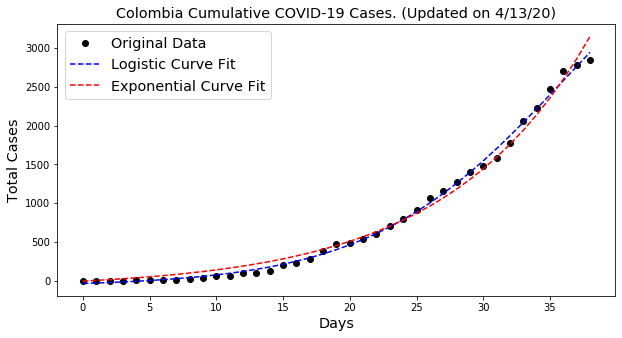



Thailand

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 2579
	Confirmed cases on 4/6/20 	 2220
	Ratio: 1.16
	Weekly increase: 16.2 %
	Daily increase: 2.2 % per day
	Doubling Time (represents recent growth): 32.4 days

** Based on Logistic Fit**

	R^2: 0.9987352339905806
	Doubling Time (during middle of growth):  6.58 (± 0.24 ) days
	param:  [1.23164145e+06 2.10832582e-01 1.92968365e+01 2.63057865e+03]

** Based on Exponential Fit **

	R^2: 0.9507926884515395
	Doubling Time (represents overall growth):  10.93 (± 1.27 ) days
	param:  [ 1.77879289e+01  6.34155073e-02 -1.00000000e+02]


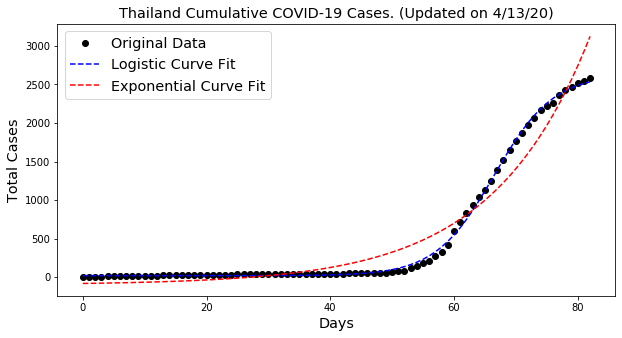



South Africa

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 2272
	Confirmed cases on 4/6/20 	 1686
	Ratio: 1.35
	Weekly increase: 34.8 %
	Daily increase: 4.4 % per day
	Doubling Time (represents recent growth): 16.3 days

** Based on Logistic Fit**

	R^2: 0.9845114039568166
	Doubling Time (during middle of growth):  6.81 (± 1.34 ) days
	param:  [ 1.09046157e+02  2.03500985e-01 -7.75193081e+01  2.12778738e+03]

 exponential R^2  0.8856183147991405


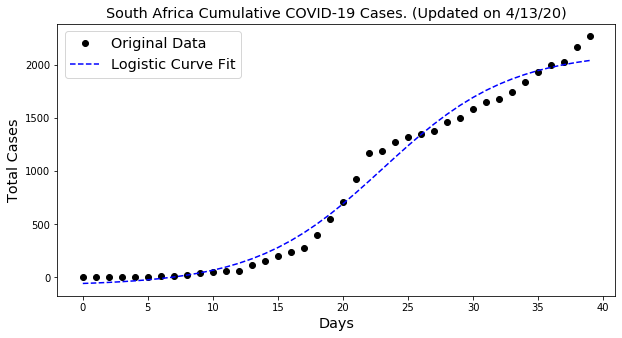



Argentina

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 2208
	Confirmed cases on 4/6/20 	 1554
	Ratio: 1.42
	Weekly increase: 42.1 %
	Daily increase: 5.1 % per day
	Doubling Time (represents recent growth): 13.8 days

** Based on Logistic Fit**

	R^2: 0.9971211803972655
	Doubling Time (during middle of growth):  8.03 (± 0.73 ) days
	param:  [ 2.02905477e+02  1.72614830e-01 -3.77297232e+01  2.51499768e+03]

** Based on Exponential Fit **

	R^2: 0.9710518647757733
	Doubling Time (represents overall growth):  8.73 (± 1.42 ) days
	param:  [ 1.00000000e+02  7.94340379e-02 -1.00000000e+02]


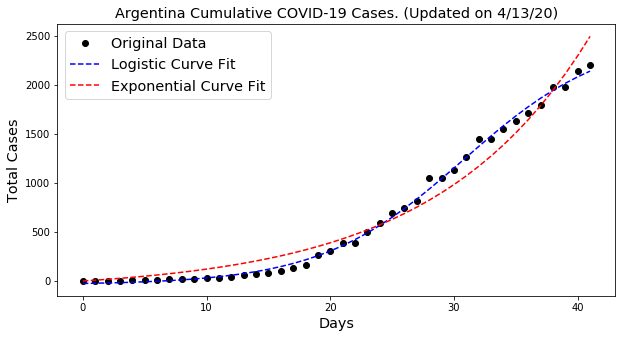



Egypt

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 2190
	Confirmed cases on 4/6/20 	 1322
	Ratio: 1.66
	Weekly increase: 65.7 %
	Daily increase: 7.5 % per day
	Doubling Time (represents recent growth): 9.6 days

** Based on Logistic Fit**

	R^2: 0.9984634682689232
	Doubling Time (during middle of growth):  13.05 (± 0.9 ) days
	param:  [ 8.91819110e+02  1.06262270e-01 -2.36100248e+01  6.00499987e+03]

** Based on Exponential Fit **

	R^2: 0.9971036394724259
	Doubling Time (represents overall growth):  8.41 (± 0.28 ) days
	param:  [ 18.19949362   0.08238633 -57.61411991]


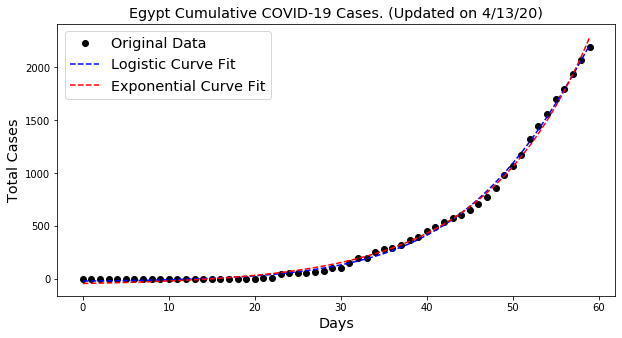



Greece

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 2145
	Confirmed cases on 4/6/20 	 1755
	Ratio: 1.22
	Weekly increase: 22.2 %
	Daily increase: 2.9 % per day
	Doubling Time (represents recent growth): 24.2 days

** Based on Logistic Fit**

	R^2: 0.9988294728944914
	Doubling Time (during middle of growth):  10.23 (± 0.57 ) days
	param:  [ 8.16510537e+01  1.35456131e-01 -5.11351616e+01  2.45268274e+03]

 exponential R^2  0.9444274611301647


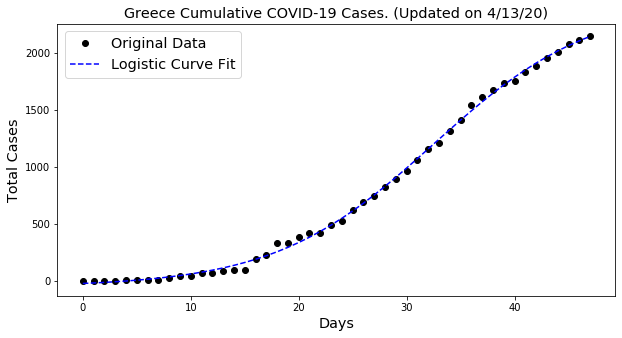



Algeria

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 1983
	Confirmed cases on 4/6/20 	 1423
	Ratio: 1.39
	Weekly increase: 39.4 %
	Daily increase: 4.9 % per day
	Doubling Time (represents recent growth): 14.6 days

** Based on Logistic Fit**

	R^2: 0.9983979531402134
	Doubling Time (during middle of growth):  6.69 (± 0.38 ) days
	param:  [2.74094992e+03 2.07077900e-01 4.05430982e+00 2.20644984e+03]

** Based on Exponential Fit **

	R^2: 0.9746000364685707
	Doubling Time (represents overall growth):  8.46 (± 1.05 ) days
	param:  [ 4.60565074e+01  8.19258906e-02 -1.00000000e+02]


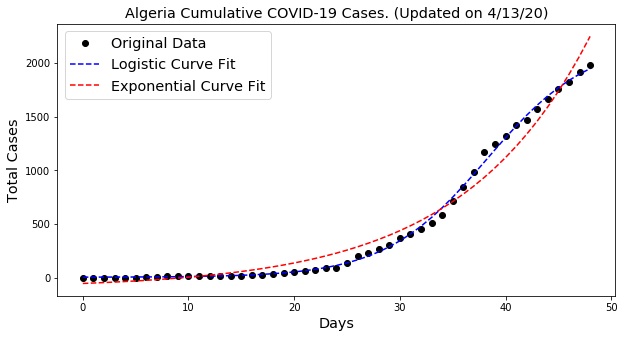



Morocco

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 1763
	Confirmed cases on 4/6/20 	 1120
	Ratio: 1.57
	Weekly increase: 57.4 %
	Daily increase: 6.7 % per day
	Doubling Time (represents recent growth): 10.7 days

** Based on Logistic Fit**

	R^2: 0.99845506110287
	Doubling Time (during middle of growth):  8.32 (± 0.58 ) days
	param:  [ 3.60501239e+02  1.66552474e-01 -2.44198672e+01  2.29820973e+03]

** Based on Exponential Fit **

	R^2: 0.9873327029641048
	Doubling Time (represents overall growth):  8.1 (± 0.79 ) days
	param:  [ 5.51265329e+01  8.55372595e-02 -1.00000000e+02]


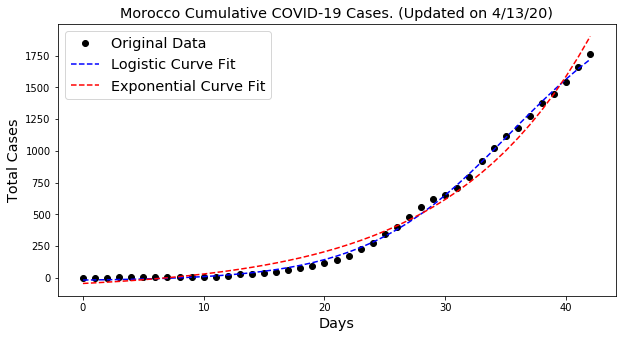



Moldova

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 1712
	Confirmed cases on 4/6/20 	 965
	Ratio: 1.77
	Weekly increase: 77.4 %
	Daily increase: 8.5 % per day
	Doubling Time (represents recent growth): 8.5 days

** Based on Logistic Fit**

	R^2: 0.9988074239751418
	Doubling Time (during middle of growth):  6.58 (± 0.42 ) days
	param:  [6.65070603e+02 2.10625959e-01 8.60429523e+00 2.32907382e+03]

** Based on Exponential Fit **

	R^2: 0.9888909697131841
	Doubling Time (represents overall growth):  6.8 (± 0.66 ) days
	param:  [  50.68898264    0.10188685 -100.        ]


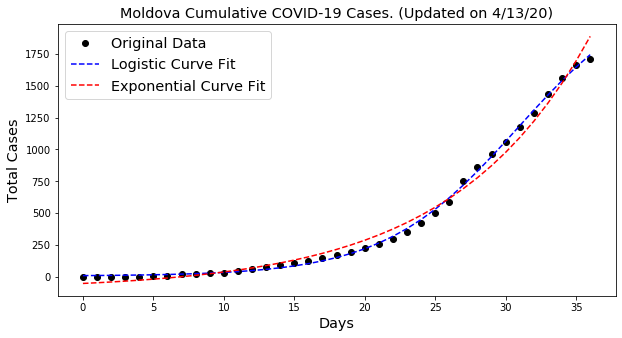



Iceland

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 1711
	Confirmed cases on 4/6/20 	 1562
	Ratio: 1.1
	Weekly increase: 9.5 %
	Daily increase: 1.3 % per day
	Doubling Time (represents recent growth): 53.3 days

** Based on Logistic Fit**

	R^2: 0.9991036913063975
	Doubling Time (during middle of growth):  8.21 (± 0.37 ) days
	param:  [ 1.21791288e+02  1.68799080e-01 -1.84220031e+01  1.83630274e+03]

 exponential R^2  0.9195515547695485


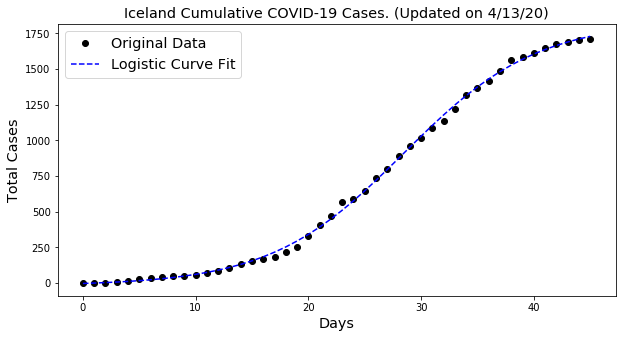



Croatia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 1650
	Confirmed cases on 4/6/20 	 1222
	Ratio: 1.35
	Weekly increase: 35.0 %
	Daily increase: 4.4 % per day
	Doubling Time (represents recent growth): 16.2 days

** Based on Logistic Fit**

	R^2: 0.9969863651519609
	Doubling Time (during middle of growth):  7.69 (± 0.6 ) days
	param:  [ 5.65693053e+02  1.80220939e-01 -1.91675340e+01  1.73809246e+03]

** Based on Exponential Fit **

	R^2: 0.9653100920156314
	Doubling Time (represents overall growth):  10.16 (± 1.67 ) days
	param:  [ 7.48602338e+01  6.82375380e-02 -1.00000000e+02]


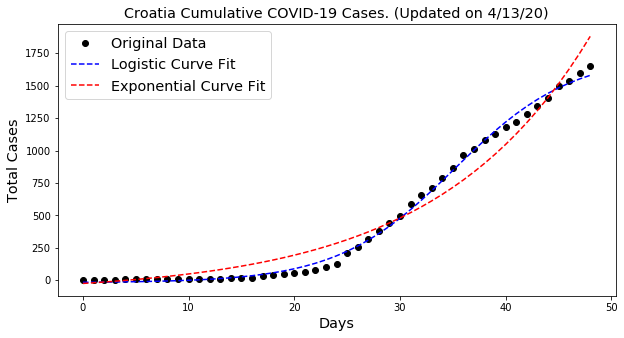



Hungary

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 1458
	Confirmed cases on 4/6/20 	 744
	Ratio: 1.96
	Weekly increase: 96.0 %
	Daily increase: 10.1 % per day
	Doubling Time (represents recent growth): 7.2 days

** Based on Logistic Fit**

	R^2: 0.9940683837528791
	Doubling Time (during middle of growth):  14.75 (± 3.85 ) days
	param:  [ 2.34489002e+02  9.39955804e-02 -6.99567621e+01  9.97706143e+03]

** Based on Exponential Fit **

	R^2: 0.9939474642476895
	Doubling Time (represents overall growth):  8.26 (± 0.59 ) days
	param:  [ 5.52160013e+01  8.39662609e-02 -8.83082407e+01]


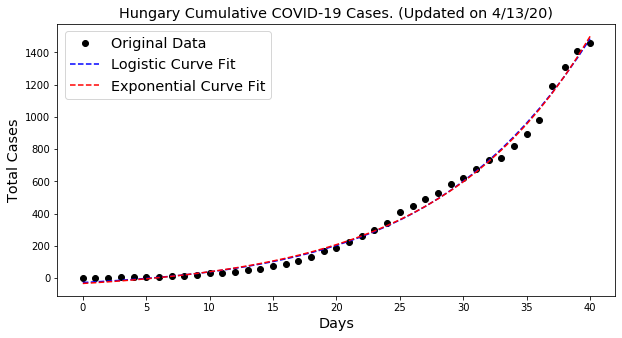



Iraq

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 1378
	Confirmed cases on 4/6/20 	 1031
	Ratio: 1.34
	Weekly increase: 33.7 %
	Daily increase: 4.2 % per day
	Doubling Time (represents recent growth): 16.7 days

** Based on Logistic Fit**

	R^2: 0.9987208155553907
	Doubling Time (during middle of growth):  9.62 (± 0.55 ) days
	param:  [3.03054698e+02 1.44152780e-01 9.93107975e+00 1.76886396e+03]

** Based on Exponential Fit **

	R^2: 0.9863877701529515
	Doubling Time (represents overall growth):  10.84 (± 1.1 ) days
	param:  [ 7.20741526e+01  6.39300176e-02 -1.00000000e+02]


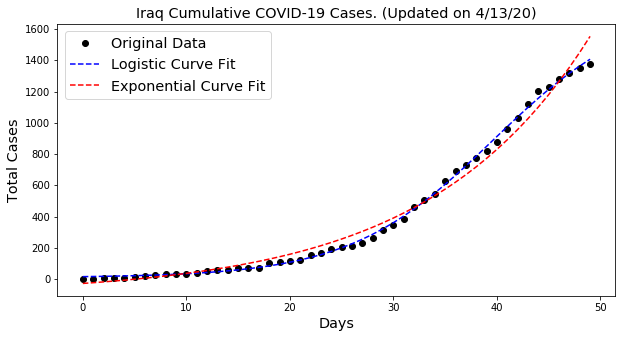



Bahrain

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 1361
	Confirmed cases on 4/6/20 	 756
	Ratio: 1.8
	Weekly increase: 80.0 %
	Daily increase: 8.8 % per day
	Doubling Time (represents recent growth): 8.3 days

** Based on Logistic Fit**

	R^2: 0.9871611441003351
	Doubling Time (during middle of growth):  26.69 (± 3.3 ) days
	param:  [ 1.80822137e+08  5.19320531e-02 -8.37923655e+01  1.79549137e+10]

** Based on Exponential Fit **

	R^2: 0.9871611445267534
	Doubling Time (represents overall growth):  13.35 (± 1.5 ) days
	param:  [ 9.92953084e+01  5.19321857e-02 -8.37912821e+01]


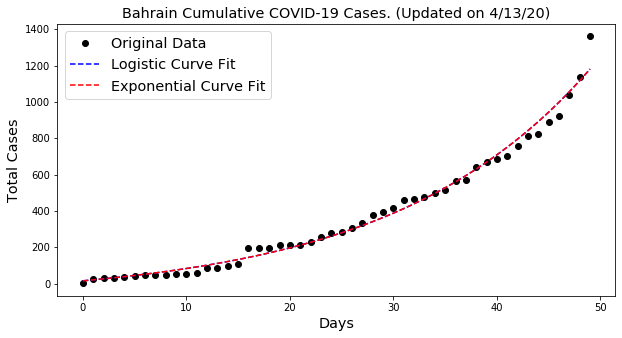



New Zealand

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 1349
	Confirmed cases on 4/6/20 	 1106
	Ratio: 1.22
	Weekly increase: 22.0 %
	Daily increase: 2.9 % per day
	Doubling Time (represents recent growth): 24.4 days

** Based on Logistic Fit**

	R^2: 0.9985440796102255
	Doubling Time (during middle of growth):  5.65 (± 0.3 ) days
	param:  [ 3.03268919e+03  2.45542583e-01 -9.65642313e+00  1.40645330e+03]

** Based on Exponential Fit **

	R^2: 0.9506276863084067
	Doubling Time (represents overall growth):  9.23 (± 1.84 ) days
	param:  [ 5.89016929e+01  7.51242630e-02 -1.00000000e+02]


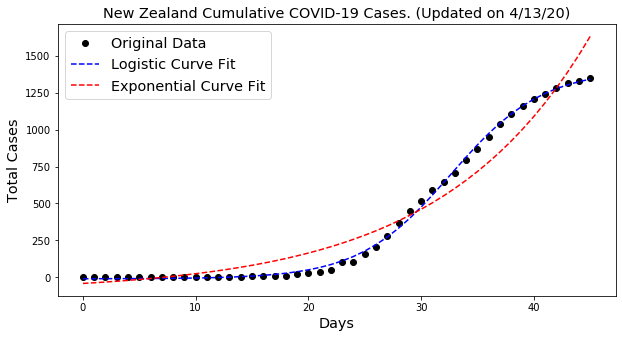



Estonia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 1332
	Confirmed cases on 4/6/20 	 1108
	Ratio: 1.2
	Weekly increase: 20.2 %
	Daily increase: 2.7 % per day
	Doubling Time (represents recent growth): 26.4 days

** Based on Logistic Fit**

	R^2: 0.9957308316971151
	Doubling Time (during middle of growth):  10.15 (± 1.12 ) days
	param:  [ 8.89389133e+01  1.36598038e-01 -3.70076049e+01  1.58223019e+03]

** Based on Exponential Fit **

	R^2: 0.9654435410864226
	Doubling Time (represents overall growth):  11.28 (± 2.06 ) days
	param:  [ 1.00000000e+02  6.14271962e-02 -1.00000000e+02]


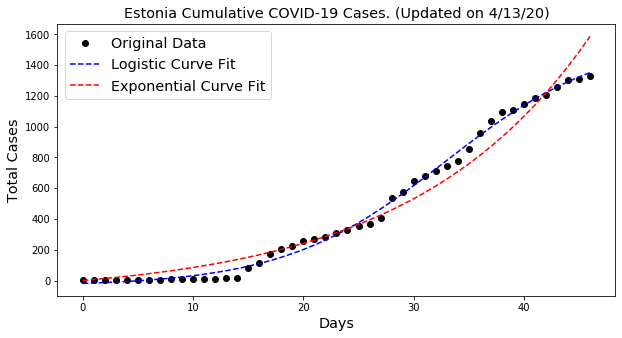



Kuwait

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 1300
	Confirmed cases on 4/6/20 	 665
	Ratio: 1.95
	Weekly increase: 95.5 %
	Daily increase: 10.0 % per day
	Doubling Time (represents recent growth): 7.2 days

** Based on Logistic Fit**

	R^2: 0.9919203268062164
	Doubling Time (during middle of growth):  10.42 (± 1.86 ) days
	param:  [2.60233595e+03 1.33071458e-01 5.33011512e+01 6.35538438e+03]

** Based on Exponential Fit **

	R^2: 0.9916497915228003
	Doubling Time (represents overall growth):  5.96 (± 0.35 ) days
	param:  [ 4.46661581  0.11625619 44.10133069]


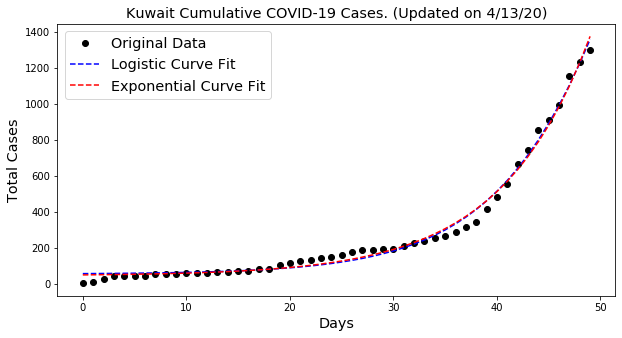



Slovenia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 1212
	Confirmed cases on 4/6/20 	 1021
	Ratio: 1.19
	Weekly increase: 18.7 %
	Daily increase: 2.5 % per day
	Doubling Time (represents recent growth): 28.3 days

** Based on Logistic Fit**

	R^2: 0.9981696734265769
	Doubling Time (during middle of growth):  12.9 (± 1.44 ) days
	param:  [ 1.14155016e+01  1.07480227e-01 -1.47362433e+02  1.46348391e+03]

 exponential R^2  0.9115313410301695


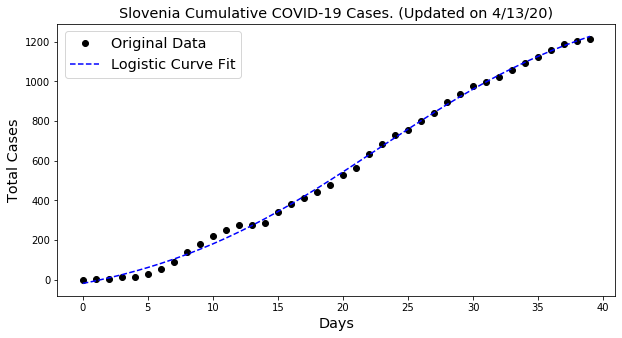



Azerbaijan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 1148
	Confirmed cases on 4/6/20 	 641
	Ratio: 1.79
	Weekly increase: 79.1 %
	Daily increase: 8.7 % per day
	Doubling Time (represents recent growth): 8.3 days

** Based on Logistic Fit**

	R^2: 0.9990343370450246
	Doubling Time (during middle of growth):  7.13 (± 0.37 ) days
	param:  [1.51709329e+03 1.94485328e-01 3.95667558e+00 1.58129940e+03]

** Based on Exponential Fit **

	R^2: 0.9882616900995206
	Doubling Time (represents overall growth):  6.97 (± 0.59 ) days
	param:  [ 18.37767695   0.09941836 -48.78768243]


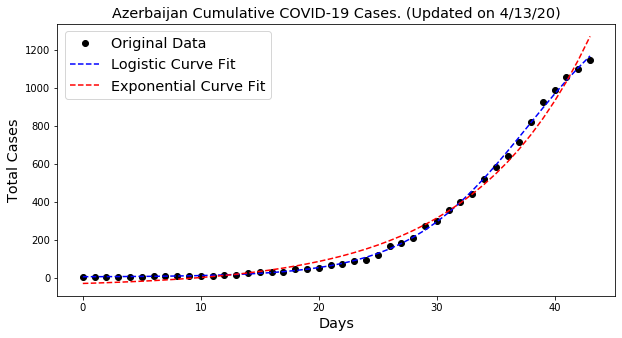



Kazakhstan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 1091
	Confirmed cases on 4/6/20 	 662
	Ratio: 1.65
	Weekly increase: 64.8 %
	Daily increase: 7.4 % per day
	Doubling Time (represents recent growth): 9.7 days

** Based on Logistic Fit**

	R^2: 0.9930100792569013
	Doubling Time (during middle of growth):  8.71 (± 1.89 ) days
	param:  [ 5.31851606e+01  1.59126984e-01 -3.49976601e+01  1.41121563e+03]

** Based on Exponential Fit **

	R^2: 0.9842866994508909
	Doubling Time (represents overall growth):  8.5 (± 1.37 ) days
	param:  [ 9.61068557e+01  8.15686172e-02 -1.00000000e+02]


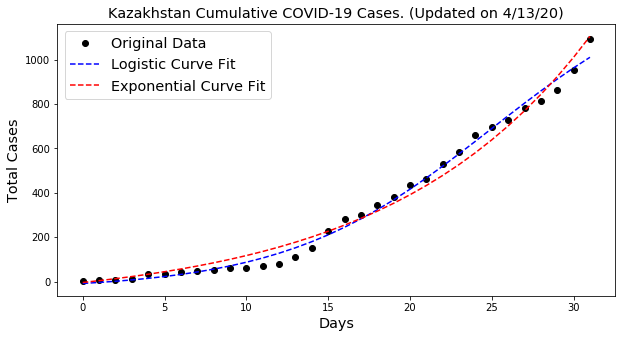



Lithuania

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 1062
	Confirmed cases on 4/6/20 	 843
	Ratio: 1.26
	Weekly increase: 26.0 %
	Daily increase: 3.4 % per day
	Doubling Time (represents recent growth): 21.0 days

** Based on Logistic Fit**

	R^2: 0.9977638384661764
	Doubling Time (during middle of growth):  6.92 (± 0.48 ) days
	param:  [ 6.41556229e+02  2.00331136e-01 -1.60474522e+01  1.13390658e+03]

** Based on Exponential Fit **

	R^2: 0.961792100198227
	Doubling Time (represents overall growth):  10.3 (± 1.92 ) days
	param:  [ 6.53856826e+01  6.73213712e-02 -1.00000000e+02]


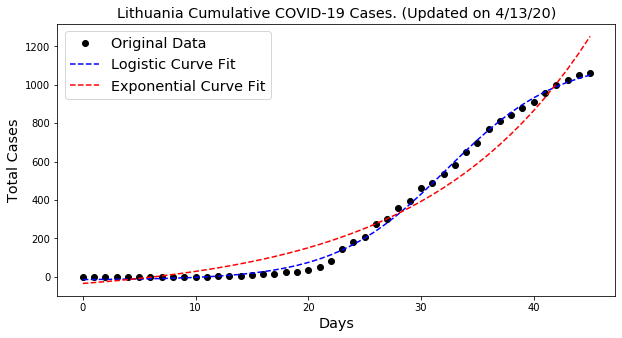



Armenia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 1039
	Confirmed cases on 4/6/20 	 833
	Ratio: 1.25
	Weekly increase: 24.7 %
	Daily increase: 3.2 % per day
	Doubling Time (represents recent growth): 22.0 days

** Based on Logistic Fit**

	R^2: 0.9977529574887769
	Doubling Time (during middle of growth):  7.76 (± 0.57 ) days
	param:  [ 2.16757950e+02  1.78539088e-01 -1.53844802e+01  1.12481286e+03]

** Based on Exponential Fit **

	R^2: 0.965280597545509
	Doubling Time (represents overall growth):  10.97 (± 2.16 ) days
	param:  [ 8.57459429e+01  6.32093942e-02 -1.00000000e+02]


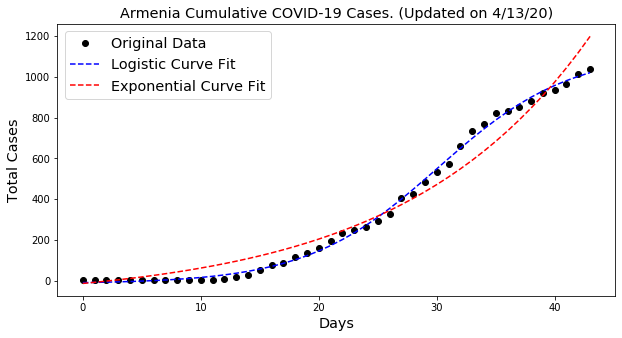



Bosnia and Herzegovina

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 1037
	Confirmed cases on 4/6/20 	 674
	Ratio: 1.54
	Weekly increase: 53.9 %
	Daily increase: 6.3 % per day
	Doubling Time (represents recent growth): 11.3 days

** Based on Logistic Fit**

	R^2: 0.9985305935883345
	Doubling Time (during middle of growth):  8.48 (± 0.61 ) days
	param:  [ 1.45334374e+02  1.63415745e-01 -1.68721059e+01  1.28468063e+03]

** Based on Exponential Fit **

	R^2: 0.9854027353536708
	Doubling Time (represents overall growth):  9.59 (± 1.22 ) days
	param:  [ 7.41371413e+01  7.22724914e-02 -1.00000000e+02]


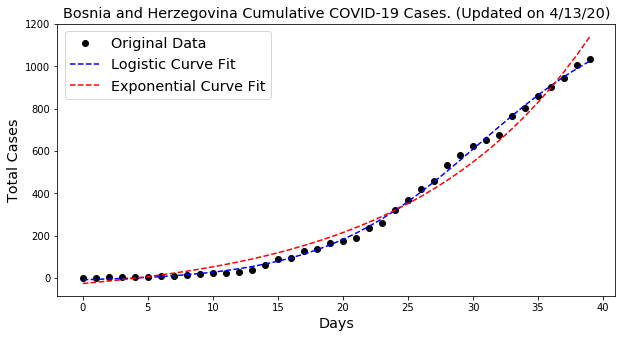



Uzbekistan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 998
	Confirmed cases on 4/6/20 	 457
	Ratio: 2.18
	Weekly increase: 118.4 %
	Daily increase: 11.8 % per day
	Doubling Time (represents recent growth): 6.2 days

** Based on Logistic Fit**

	R^2: 0.9934324734649965
	Doubling Time (during middle of growth):  9.38 (± 2.64 ) days
	param:  [ 2.59545733e+02  1.47846442e-01 -1.07269041e+01  4.51481949e+03]

** Based on Exponential Fit **

	R^2: 0.993176314043049
	Doubling Time (represents overall growth):  5.51 (± 0.47 ) days
	param:  [ 26.45930144   0.12588561 -25.80449506]


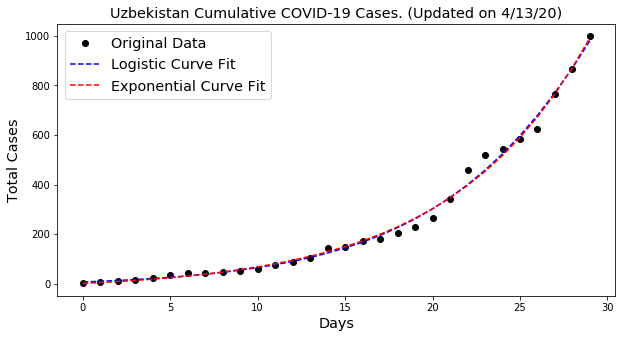



North Macedonia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 854
	Confirmed cases on 4/6/20 	 570
	Ratio: 1.5
	Weekly increase: 49.8 %
	Daily increase: 5.9 % per day
	Doubling Time (represents recent growth): 12.0 days

** Based on Logistic Fit**

	R^2: 0.9972914864017824
	Doubling Time (during middle of growth):  9.76 (± 0.87 ) days
	param:  [ 3.14282721e+02  1.42001838e-01 -1.44328366e+01  1.17844262e+03]

** Based on Exponential Fit **

	R^2: 0.989041030608572
	Doubling Time (represents overall growth):  9.59 (± 0.84 ) days
	param:  [ 32.83316938   0.07226431 -69.63430426]


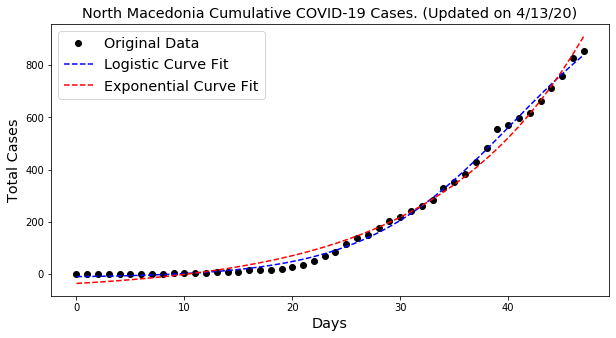



Cameroon

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 820
	Confirmed cases on 4/6/20 	 658
	Ratio: 1.25
	Weekly increase: 24.6 %
	Daily increase: 3.2 % per day
	Doubling Time (represents recent growth): 22.0 days

** Based on Logistic Fit**

	R^2: 0.9922447906111457
	Doubling Time (during middle of growth):  3.43 (± 0.47 ) days
	param:  [7.52126724e+04 4.04573467e-01 1.41777171e+01 8.32746573e+02]

 exponential R^2  0.9367981365693276


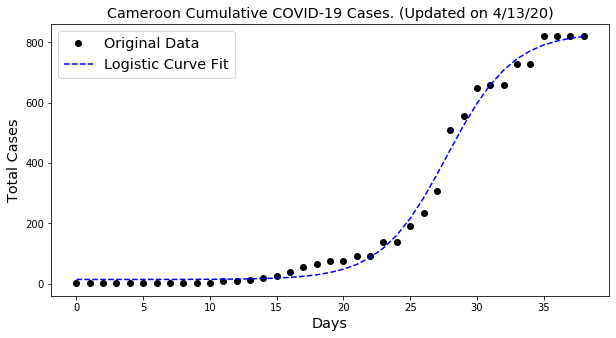



Bangladesh

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 803
	Confirmed cases on 4/6/20 	 123
	Ratio: 6.53
	Weekly increase: 552.8 %
	Daily increase: 30.7 % per day
	Doubling Time (represents recent growth): 2.6 days

Exception in logstic process 
<class 'RuntimeError'>
Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

** Based on Exponential Fit **

	R^2: 0.992042410190992
	Doubling Time (represents overall growth):  2.68 (± 0.17 ) days
	param:  [ 0.07092679  0.25898526 15.11732193]


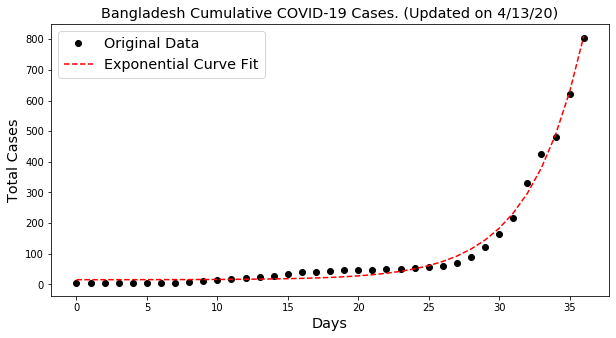



Slovakia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 769
	Confirmed cases on 4/6/20 	 534
	Ratio: 1.44
	Weekly increase: 44.0 %
	Daily increase: 5.3 % per day
	Doubling Time (represents recent growth): 13.3 days

** Based on Logistic Fit**

	R^2: 0.9946624599511429
	Doubling Time (during middle of growth):  15.68 (± 4.22 ) days
	param:  [ 2.26030828e+01  8.84313421e-02 -7.86042588e+01  1.47994307e+03]

** Based on Exponential Fit **

	R^2: 0.9875435763465482
	Doubling Time (represents overall growth):  11.7 (± 1.63 ) days
	param:  [ 1.00000000e+02  5.92477457e-02 -9.62501950e+01]


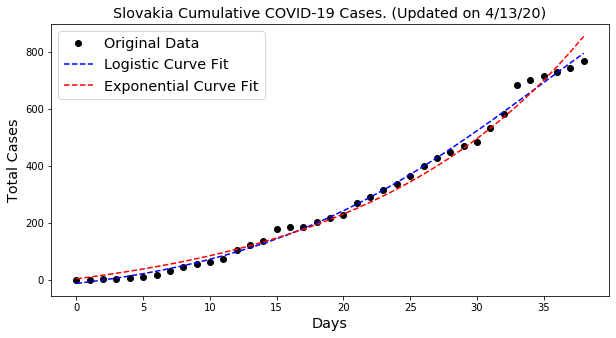



Oman

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 727
	Confirmed cases on 4/6/20 	 331
	Ratio: 2.2
	Weekly increase: 119.6 %
	Daily increase: 11.9 % per day
	Doubling Time (represents recent growth): 6.2 days

** Based on Logistic Fit**

	R^2: 0.9963352628959717
	Doubling Time (during middle of growth):  13.76 (± 1.7 ) days
	param:  [ 4.57528690e+08  1.00718417e-01 -5.26885900e+00  2.27989851e+09]

** Based on Exponential Fit **

	R^2: 0.9963352632003293
	Doubling Time (represents overall growth):  6.88 (± 0.28 ) days
	param:  [ 4.98307499  0.1007184  -5.26886399]


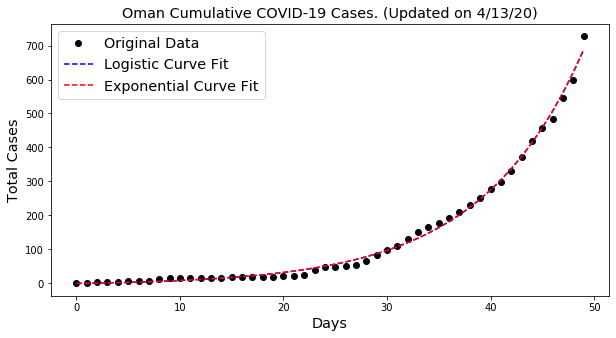



Cuba

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 726
	Confirmed cases on 4/6/20 	 350
	Ratio: 2.07
	Weekly increase: 107.4 %
	Daily increase: 11.0 % per day
	Doubling Time (represents recent growth): 6.7 days

** Based on Logistic Fit**

	R^2: 0.9980629470803088
	Doubling Time (during middle of growth):  10.01 (± 1.33 ) days
	param:  [ 1.05813057e+02  1.38533243e-01 -2.42849805e+01  1.67192447e+03]

** Based on Exponential Fit **

	R^2: 0.996524376401409
	Doubling Time (represents overall growth):  7.35 (± 0.47 ) days
	param:  [ 39.57472683   0.09429261 -59.06385065]


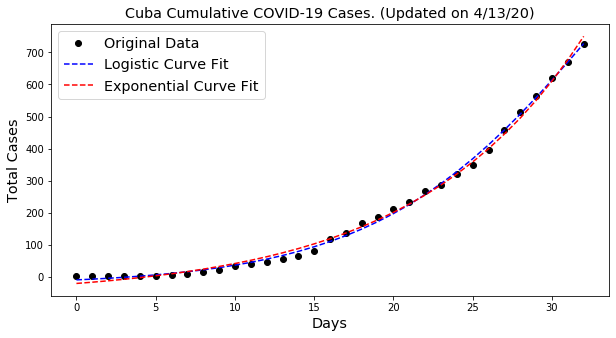



Tunisia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 726
	Confirmed cases on 4/6/20 	 596
	Ratio: 1.22
	Weekly increase: 21.8 %
	Daily increase: 2.9 % per day
	Doubling Time (represents recent growth): 24.6 days

** Based on Logistic Fit**

	R^2: 0.998433152019682
	Doubling Time (during middle of growth):  6.07 (± 0.36 ) days
	param:  [ 4.40997633e+02  2.28300520e-01 -3.81142601e+00  7.39736582e+02]

** Based on Exponential Fit **

	R^2: 0.9556026048746042
	Doubling Time (represents overall growth):  11.19 (± 2.77 ) days
	param:  [ 7.96589102e+01  6.19511027e-02 -1.00000000e+02]


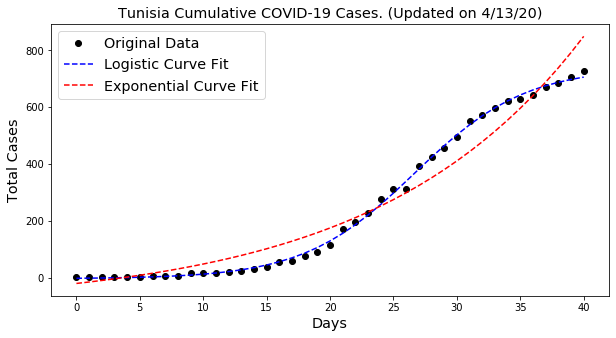



Diamond Princess

** Based on Logistic Fit**

	R^2: 0.996349603726563
	Doubling Time (during middle of growth):  2.83 (± 0.21 ) days
	param:  [8.92440191e+01 4.90333238e-01 6.84995921e+01 7.08920180e+02]

 exponential R^2  -0.7116340489481014


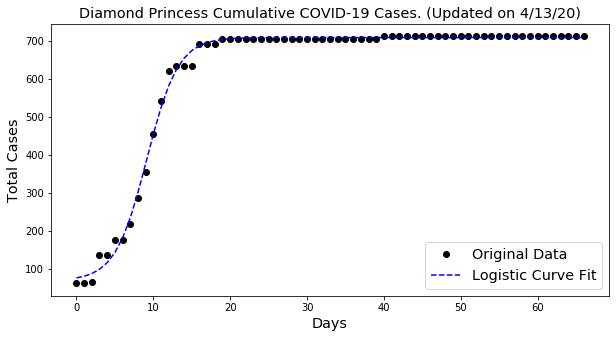



Bulgaria

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 685
	Confirmed cases on 4/6/20 	 549
	Ratio: 1.25
	Weekly increase: 24.8 %
	Daily increase: 3.2 % per day
	Doubling Time (represents recent growth): 21.9 days

** Based on Logistic Fit**

	R^2: 0.9988414089648515
	Doubling Time (during middle of growth):  11.14 (± 0.96 ) days
	param:  [ 1.57717358e+01  1.24457231e-01 -6.48540033e+01  8.19201679e+02]

** Based on Exponential Fit **

	R^2: 0.9552814143675217
	Doubling Time (represents overall growth):  11.57 (± 3.35 ) days
	param:  [ 1.00000000e+02  5.99187120e-02 -6.16052657e+01]


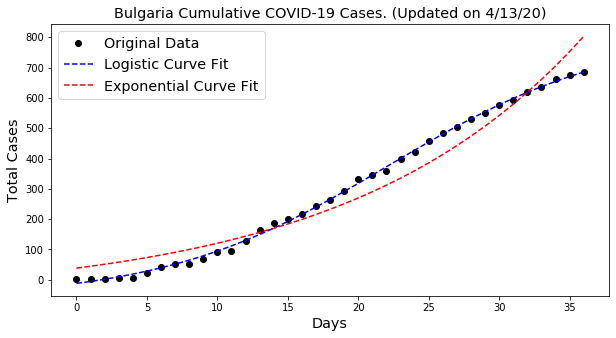



Afghanistan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 665
	Confirmed cases on 4/6/20 	 367
	Ratio: 1.81
	Weekly increase: 81.2 %
	Daily increase: 8.9 % per day
	Doubling Time (represents recent growth): 8.2 days

** Based on Logistic Fit**

	R^2: 0.9972627710385173
	Doubling Time (during middle of growth):  8.39 (± 0.7 ) days
	param:  [ 1.52949485e+03  1.65158195e-01 -2.82733359e+00  9.42991681e+02]

** Based on Exponential Fit **

	R^2: 0.9897729303296485
	Doubling Time (represents overall growth):  7.37 (± 0.52 ) days
	param:  [  7.16768588   0.09406632 -24.27580732]


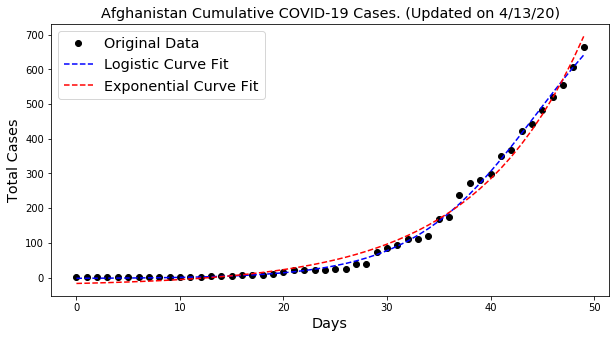



Cyprus

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 662
	Confirmed cases on 4/6/20 	 465
	Ratio: 1.42
	Weekly increase: 42.4 %
	Daily increase: 5.2 % per day
	Doubling Time (represents recent growth): 13.7 days

** Based on Logistic Fit**

	R^2: 0.9977373445753761
	Doubling Time (during middle of growth):  8.63 (± 0.87 ) days
	param:  [ 6.43096010e+01  1.60701368e-01 -5.04821147e+00  8.13924025e+02]

** Based on Exponential Fit **

	R^2: 0.9861795256896468
	Doubling Time (represents overall growth):  11.16 (± 1.77 ) days
	param:  [ 9.39850093e+01  6.20955132e-02 -1.00000000e+02]


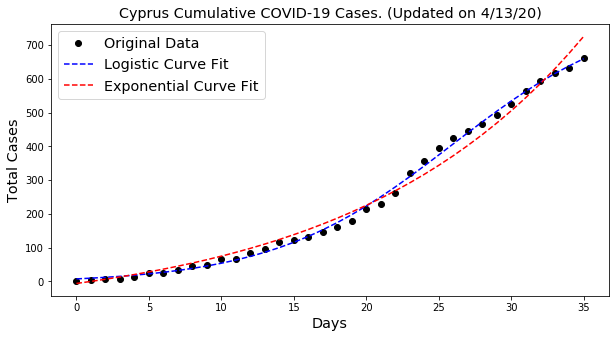



Latvia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 655
	Confirmed cases on 4/6/20 	 542
	Ratio: 1.21
	Weekly increase: 20.8 %
	Daily increase: 2.7 % per day
	Doubling Time (represents recent growth): 25.6 days

** Based on Logistic Fit**

	R^2: 0.998735012713937
	Doubling Time (during middle of growth):  7.68 (± 0.42 ) days
	param:  [ 1.26325658e+02  1.80412373e-01 -1.40444633e+01  6.83081939e+02]

** Based on Exponential Fit **

	R^2: 0.9591631366147533
	Doubling Time (represents overall growth):  13.04 (± 3.28 ) days
	param:  [ 9.29080850e+01  5.31644651e-02 -1.00000000e+02]


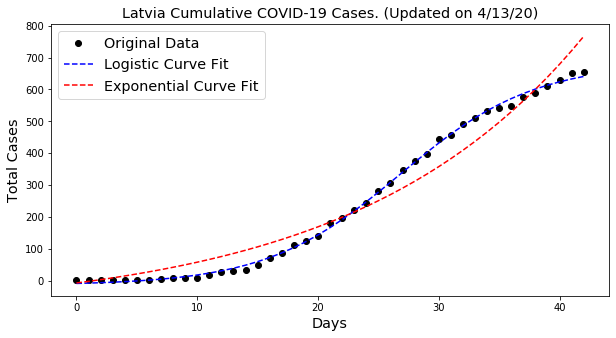



Andorra

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 646
	Confirmed cases on 4/6/20 	 525
	Ratio: 1.23
	Weekly increase: 23.0 %
	Daily increase: 3.0 % per day
	Doubling Time (represents recent growth): 23.4 days

** Based on Logistic Fit**

	R^2: 0.9961939001602916
	Doubling Time (during middle of growth):  7.24 (± 0.68 ) days
	param:  [ 1.89014124e+02  1.91404594e-01 -1.71207318e+01  6.62774746e+02]

** Based on Exponential Fit **

	R^2: 0.9576490706811296
	Doubling Time (represents overall growth):  12.38 (± 3.04 ) days
	param:  [ 8.09580221e+01  5.59871719e-02 -1.00000000e+02]


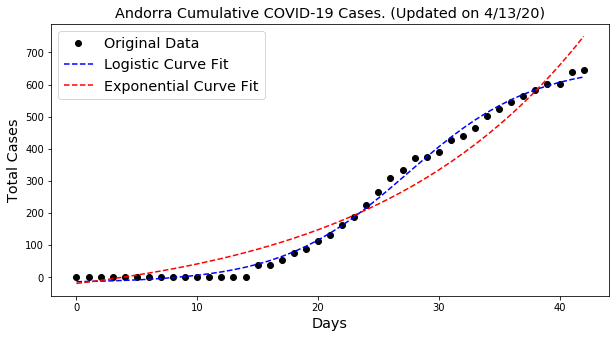



Lebanon

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 632
	Confirmed cases on 4/6/20 	 541
	Ratio: 1.17
	Weekly increase: 16.8 %
	Daily increase: 2.2 % per day
	Doubling Time (represents recent growth): 31.2 days

** Based on Logistic Fit**

	R^2: 0.9968887586608444
	Doubling Time (during middle of growth):  8.23 (± 0.6 ) days
	param:  [ 2.53345333e+02  1.68497310e-01 -4.30085598e+00  6.34960226e+02]

** Based on Exponential Fit **

	R^2: 0.952211321353785
	Doubling Time (represents overall growth):  16.07 (± 3.92 ) days
	param:  [ 8.98340789e+01  4.31214495e-02 -1.00000000e+02]


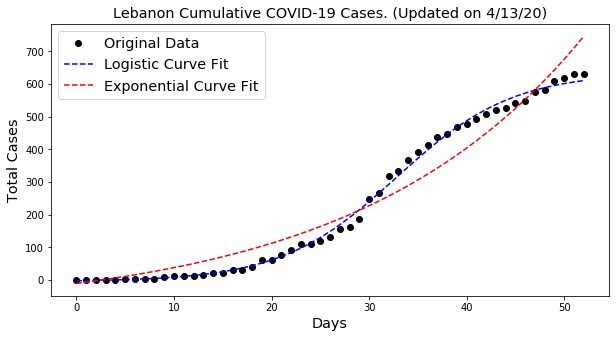



Cote d'Ivoire

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 626
	Confirmed cases on 4/6/20 	 323
	Ratio: 1.94
	Weekly increase: 93.8 %
	Daily increase: 9.9 % per day
	Doubling Time (represents recent growth): 7.3 days

** Based on Logistic Fit**

	R^2: 0.9929077318295381
	Doubling Time (during middle of growth):  14.29 (± 5.51 ) days
	param:  [ 1.88445875e+02  9.70431720e-02 -4.60225394e+01  5.77873310e+03]

** Based on Exponential Fit **

	R^2: 0.9928549852633312
	Doubling Time (represents overall growth):  7.82 (± 0.73 ) days
	param:  [ 36.66745009   0.08865604 -53.74575707]


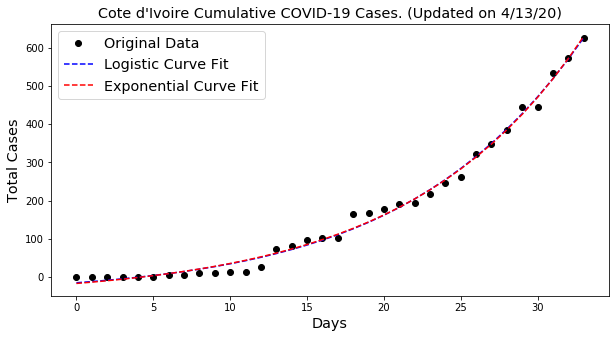



Costa Rica

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 612
	Confirmed cases on 4/6/20 	 467
	Ratio: 1.31
	Weekly increase: 31.0 %
	Daily increase: 3.9 % per day
	Doubling Time (represents recent growth): 17.9 days

** Based on Logistic Fit**

	R^2: 0.9963753391321212
	Doubling Time (during middle of growth):  9.42 (± 1.13 ) days
	param:  [ 3.38254097e+01  1.47092969e-01 -3.10149747e+01  6.69876989e+02]

** Based on Exponential Fit **

	R^2: 0.9663275736558223
	Doubling Time (represents overall growth):  12.73 (± 3.18 ) days
	param:  [ 1.00000000e+02  5.44459977e-02 -9.63168460e+01]


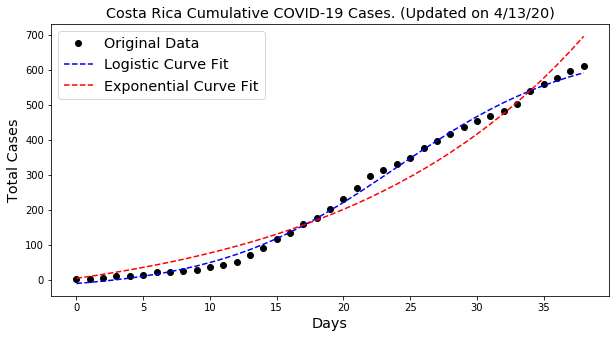



Ghana

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 566
	Confirmed cases on 4/6/20 	 214
	Ratio: 2.64
	Weekly increase: 164.5 %
	Daily increase: 14.9 % per day
	Doubling Time (represents recent growth): 5.0 days

** Based on Logistic Fit**

	R^2: 0.9651776561020796
	Doubling Time (during middle of growth):  15.69 (± 11.76 ) days
	param:  [ 6.64591378e+07  8.83629216e-02 -3.72086433e+01  2.72835843e+09]

** Based on Exponential Fit **

	R^2: 0.9651776583583318
	Doubling Time (represents overall growth):  7.84 (± 1.84 ) days
	param:  [ 41.05257229   0.08836338 -37.20765947]


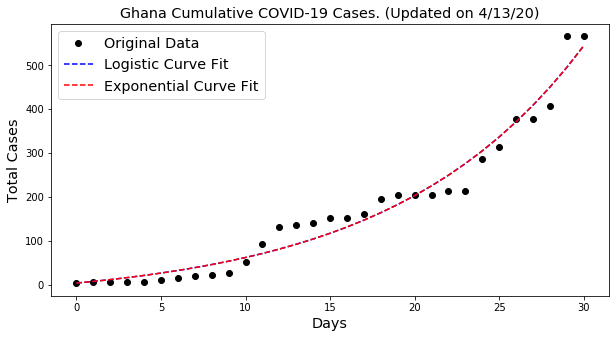



Niger

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 529
	Confirmed cases on 4/6/20 	 253
	Ratio: 2.09
	Weekly increase: 109.1 %
	Daily increase: 11.1 % per day
	Doubling Time (represents recent growth): 6.6 days

** Based on Logistic Fit**

	R^2: 0.9978483938871282
	Doubling Time (during middle of growth):  3.97 (± 0.39 ) days
	param:  [ 5.87872004e+02  3.49555548e-01 -1.18945716e+00  6.14750059e+02]

** Based on Exponential Fit **

	R^2: 0.9741955738938948
	Doubling Time (represents overall growth):  6.0 (± 1.31 ) days
	param:  [ 42.33571532   0.11547244 -73.94640999]


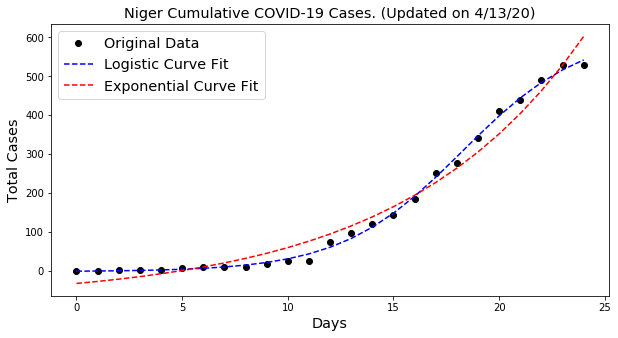



Burkina Faso

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 497
	Confirmed cases on 4/6/20 	 364
	Ratio: 1.37
	Weekly increase: 36.5 %
	Daily increase: 4.5 % per day
	Doubling Time (represents recent growth): 15.6 days

** Based on Logistic Fit**

	R^2: 0.9949052778250189
	Doubling Time (during middle of growth):  10.87 (± 2.12 ) days
	param:  [ 1.82371818e+01  1.27481000e-01 -5.28965243e+01  6.29363252e+02]

** Based on Exponential Fit **

	R^2: 0.9755898530648629
	Doubling Time (represents overall growth):  12.47 (± 3.02 ) days
	param:  [ 1.00000000e+02  5.56040792e-02 -1.00000000e+02]


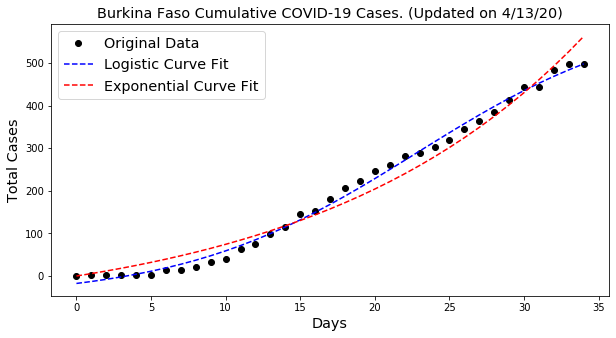



Uruguay

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 480
	Confirmed cases on 4/6/20 	 406
	Ratio: 1.18
	Weekly increase: 18.2 %
	Daily increase: 2.4 % per day
	Doubling Time (represents recent growth): 29.0 days

** Based on Logistic Fit**

	R^2: 0.9953706728405359
	Doubling Time (during middle of growth):  11.47 (± 2.82 ) days
	param:  [ 3.58263664e+00  1.20875019e-01 -1.67816002e+02  5.49233491e+02]

 exponential R^2  0.8873681222553566


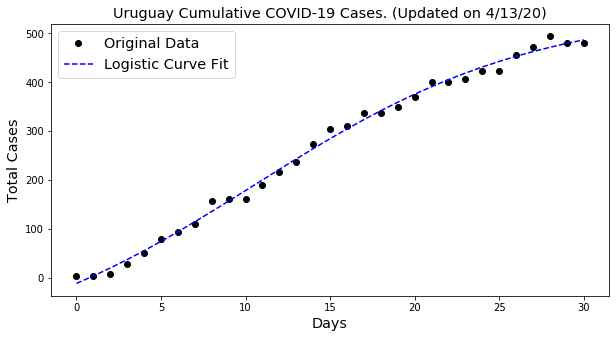



Albania

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 467
	Confirmed cases on 4/6/20 	 377
	Ratio: 1.24
	Weekly increase: 23.9 %
	Daily increase: 3.1 % per day
	Doubling Time (represents recent growth): 22.7 days

** Based on Logistic Fit**

	R^2: 0.9973425197388702
	Doubling Time (during middle of growth):  9.63 (± 1.13 ) days
	param:  [ 2.68042329e+01  1.43957013e-01 -8.57131057e+00  5.41634215e+02]

** Based on Exponential Fit **

	R^2: 0.977770978813313
	Doubling Time (represents overall growth):  13.48 (± 3.17 ) days
	param:  [ 1.00000000e+02  5.14383158e-02 -8.55183777e+01]


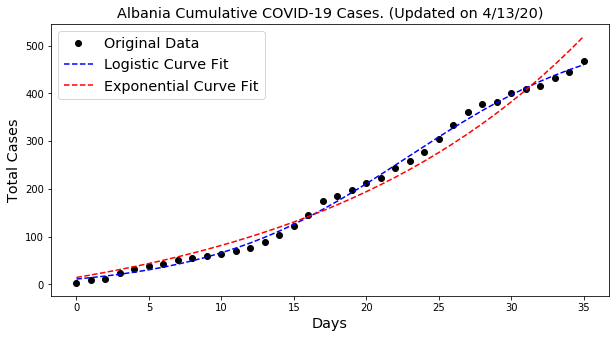



Kyrgyzstan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 419
	Confirmed cases on 4/6/20 	 216
	Ratio: 1.94
	Weekly increase: 94.0 %
	Daily increase: 9.9 % per day
	Doubling Time (represents recent growth): 7.3 days

** Based on Logistic Fit**

	R^2: 0.9928110926560151
	Doubling Time (during middle of growth):  14.81 (± 9.74 ) days
	param:  [ 2.44403884e+05  9.36030877e-02 -3.90918970e+01  9.82132456e+06]

** Based on Exponential Fit **

	R^2: 0.9928110931484492
	Doubling Time (represents overall growth):  7.41 (± 0.89 ) days
	param:  [ 40.18732794   0.0935994  -39.09480507]


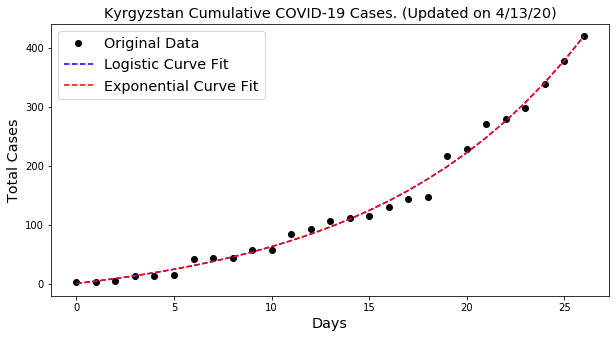



Honduras

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 397
	Confirmed cases on 4/6/20 	 298
	Ratio: 1.33
	Weekly increase: 33.2 %
	Daily increase: 4.2 % per day
	Doubling Time (represents recent growth): 16.9 days

** Based on Logistic Fit**

	R^2: 0.9961420538660519
	Doubling Time (during middle of growth):  5.97 (± 0.66 ) days
	param:  [ 1.94964649e+02  2.32306002e-01 -2.14119297e+00  4.35037850e+02]

** Based on Exponential Fit **

	R^2: 0.9721980174448794
	Doubling Time (represents overall growth):  11.45 (± 2.83 ) days
	param:  [ 7.48717212e+01  6.05391413e-02 -1.00000000e+02]


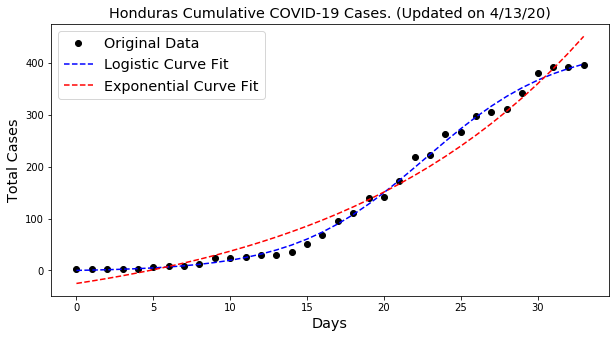



Taiwan*

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 393
	Confirmed cases on 4/6/20 	 373
	Ratio: 1.05
	Weekly increase: 5.4 %
	Daily increase: 0.7 % per day
	Doubling Time (represents recent growth): 92.9 days

** Based on Logistic Fit**

	R^2: 0.9953412290298679
	Doubling Time (during middle of growth):  6.82 (± 0.48 ) days
	param:  [2.95438140e+05 2.03248710e-01 1.91849234e+01 3.95027581e+02]

 exponential R^2  0.9437949588538945


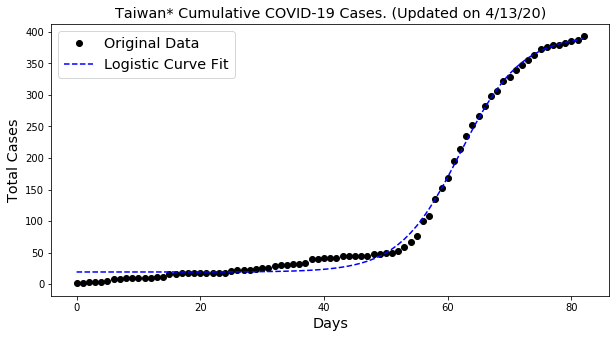



Jordan

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 391
	Confirmed cases on 4/6/20 	 349
	Ratio: 1.12
	Weekly increase: 12.0 %
	Daily increase: 1.6 % per day
	Doubling Time (represents recent growth): 42.7 days

** Based on Logistic Fit**

	R^2: 0.9949127608914282
	Doubling Time (during middle of growth):  6.62 (± 0.7 ) days
	param:  [ 1.17778950e+02  2.09454231e-01 -1.33996968e+01  3.85966995e+02]

 exponential R^2  0.93237733476269


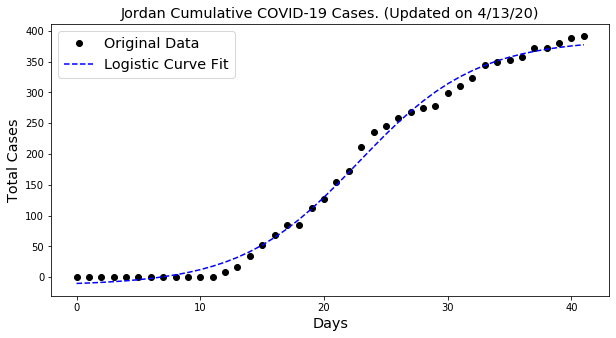



Malta

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 384
	Confirmed cases on 4/6/20 	 241
	Ratio: 1.59
	Weekly increase: 59.3 %
	Daily increase: 6.9 % per day
	Doubling Time (represents recent growth): 10.4 days

** Based on Logistic Fit**

	R^2: 0.9910788682599413
	Doubling Time (during middle of growth):  30.24 (± 36.7 ) days
	param:  [ 2.59505168e+06  4.58450691e-02 -1.01381561e+02  2.38792974e+08]

** Based on Exponential Fit **

	R^2: 0.9910773983630973
	Doubling Time (represents overall growth):  15.03 (± 2.24 ) days
	param:  [ 9.09396059e+01  4.61041968e-02 -1.00000000e+02]


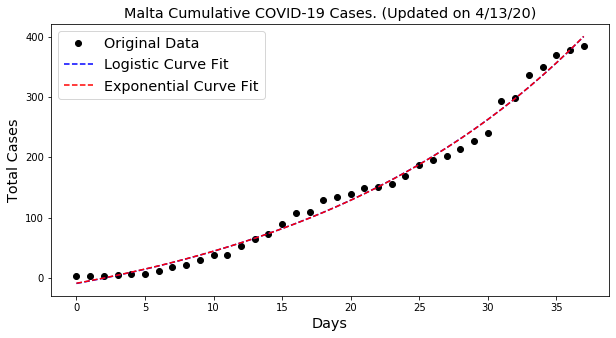



San Marino

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 356
	Confirmed cases on 4/6/20 	 266
	Ratio: 1.34
	Weekly increase: 33.8 %
	Daily increase: 4.3 % per day
	Doubling Time (represents recent growth): 16.6 days

** Based on Logistic Fit**

	R^2: 0.9858658993948669
	Doubling Time (during middle of growth):  25.72 (± 15.85 ) days
	param:  [ 5.10164876e+00  5.39032545e-02 -1.26719478e+02  5.52851490e+02]

** Based on Exponential Fit **

	R^2: 0.9638852240317781
	Doubling Time (represents overall growth):  20.43 (± 6.11 ) days
	param:  [ 1.00000000e+02  3.39296548e-02 -8.71103265e+01]


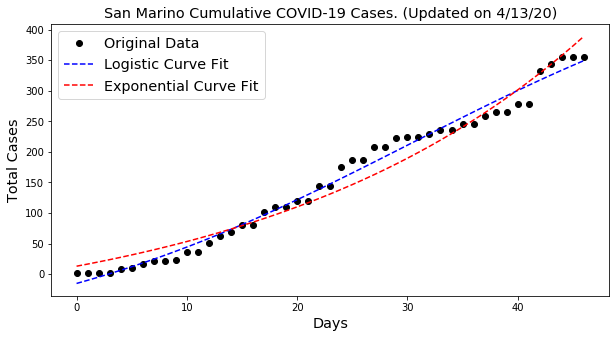



Nigeria

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 343
	Confirmed cases on 4/6/20 	 238
	Ratio: 1.44
	Weekly increase: 44.1 %
	Daily increase: 5.4 % per day
	Doubling Time (represents recent growth): 13.3 days

** Based on Logistic Fit**

	R^2: 0.9974595682464263
	Doubling Time (during middle of growth):  6.61 (± 0.49 ) days
	param:  [ 1.27913988e+03  2.09715872e-01 -2.55017612e+00  3.63593254e+02]

** Based on Exponential Fit **

	R^2: 0.9708365823287194
	Doubling Time (represents overall growth):  9.97 (± 1.54 ) days
	param:  [ 18.38829051   0.06953989 -39.07634132]


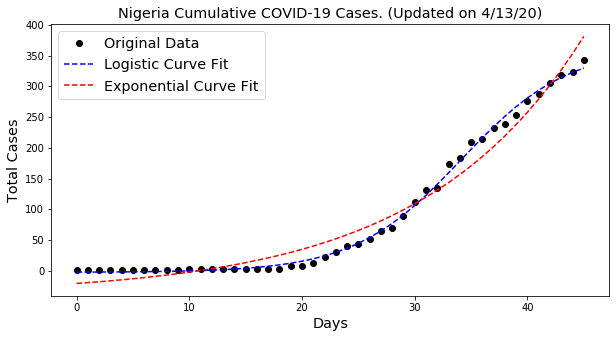



Bolivia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 330
	Confirmed cases on 4/6/20 	 183
	Ratio: 1.8
	Weekly increase: 80.3 %
	Daily increase: 8.8 % per day
	Doubling Time (represents recent growth): 8.2 days

** Based on Logistic Fit**

	R^2: 0.9941444206070931
	Doubling Time (during middle of growth):  10.75 (± 2.52 ) days
	param:  [ 7.20629055e+01  1.29007360e-01 -9.54173466e+00  6.69362340e+02]

** Based on Exponential Fit **

	R^2: 0.9922864023647137
	Doubling Time (represents overall growth):  8.57 (± 0.88 ) days
	param:  [ 25.61046      0.08086069 -31.68186824]


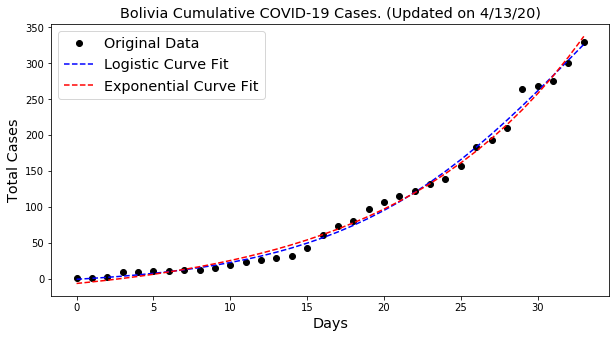



Mauritius

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 324
	Confirmed cases on 4/6/20 	 244
	Ratio: 1.33
	Weekly increase: 32.8 %
	Daily increase: 4.1 % per day
	Doubling Time (represents recent growth): 17.1 days

** Based on Logistic Fit**

	R^2: 0.9944035184432266
	Doubling Time (during middle of growth):  8.9 (± 2.25 ) days
	param:  [ 1.16100196e+01  1.55778686e-01 -3.50876362e+01  4.14505578e+02]

** Based on Exponential Fit **

	R^2: 0.9694116364976064
	Doubling Time (represents overall growth):  11.72 (± 4.36 ) days
	param:  [ 1.00000000e+02  5.91494396e-02 -8.51613955e+01]


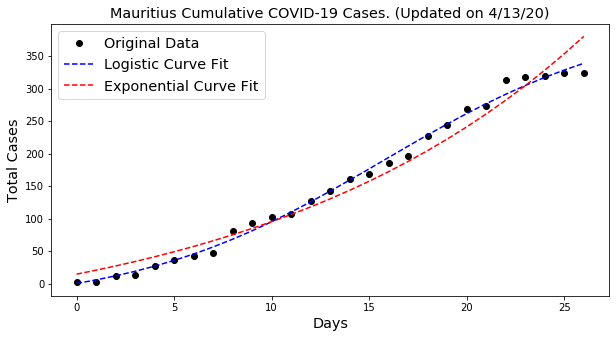



Guinea

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 319
	Confirmed cases on 4/6/20 	 128
	Ratio: 2.49
	Weekly increase: 149.2 %
	Daily increase: 13.9 % per day
	Doubling Time (represents recent growth): 5.3 days

** Based on Logistic Fit**

	R^2: 0.9891267691030449
	Doubling Time (during middle of growth):  5.73 (± 1.25 ) days
	param:  [ 7.98059499e+02  2.41748347e-01 -3.35673838e+00  4.29097533e+02]

** Based on Exponential Fit **

	R^2: 0.9814160332419231
	Doubling Time (represents overall growth):  5.18 (± 0.66 ) days
	param:  [  5.27654247   0.13393765 -15.21297089]


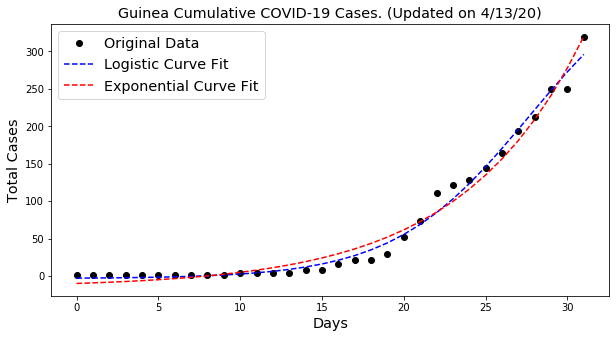



West Bank and Gaza

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 308
	Confirmed cases on 4/6/20 	 254
	Ratio: 1.21
	Weekly increase: 21.3 %
	Daily increase: 2.8 % per day
	Doubling Time (represents recent growth): 25.2 days

** Based on Logistic Fit**

	R^2: 0.9883805081758086
	Doubling Time (during middle of growth):  6.23 (± 1.07 ) days
	param:  [5.15442092e+02 2.22489716e-01 2.40192051e+01 3.22520507e+02]

** Based on Exponential Fit **

	R^2: 0.9661455582046454
	Doubling Time (represents overall growth):  12.08 (± 2.77 ) days
	param:  [ 39.57251735   0.05735724 -37.64059993]


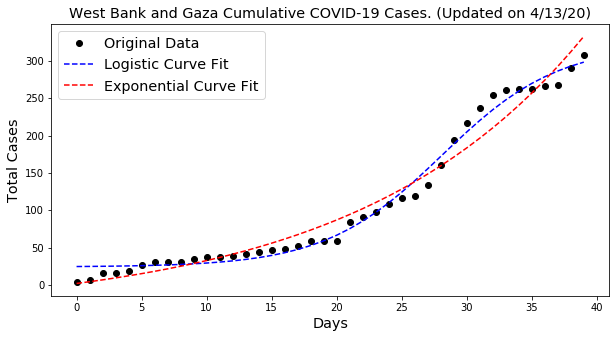



Djibouti

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 298
	Confirmed cases on 4/6/20 	 90
	Ratio: 3.31
	Weekly increase: 231.1 %
	Daily increase: 18.7 % per day
	Doubling Time (represents recent growth): 4.1 days

** Based on Logistic Fit**

	R^2: 0.9890210746493374
	Doubling Time (during middle of growth):  7.78 (± nan ) days
	param:  [ 1.76357499e+09  1.78286285e-01 -1.80285444e+00  4.79901594e+09]

** Based on Exponential Fit **

	R^2: 0.9890210749971461
	Doubling Time (represents overall growth):  3.89 (± 0.4 ) days
	param:  [ 2.72118967  0.17828623 -1.8028713 ]


/home/ma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning:

invalid value encountered in sqrt



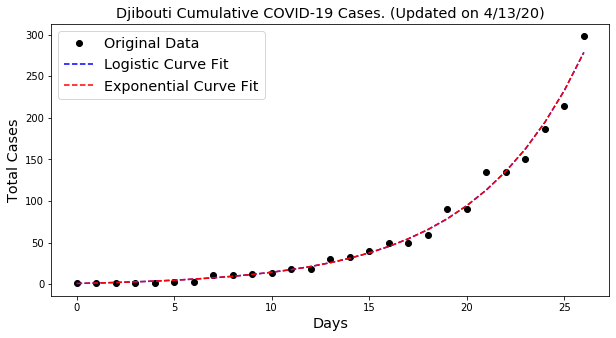



Senegal

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 291
	Confirmed cases on 4/6/20 	 226
	Ratio: 1.29
	Weekly increase: 28.8 %
	Daily increase: 3.7 % per day
	Doubling Time (represents recent growth): 19.2 days

** Based on Logistic Fit**

	R^2: 0.9971430642891047
	Doubling Time (during middle of growth):  8.08 (± 0.69 ) days
	param:  [ 1.09762657e+02  1.71615975e-01 -4.72929405e+00  3.01938996e+02]

** Based on Exponential Fit **

	R^2: 0.9745641329316442
	Doubling Time (represents overall growth):  17.65 (± 4.35 ) days
	param:  [ 8.04061894e+01  3.92641314e-02 -1.00000000e+02]


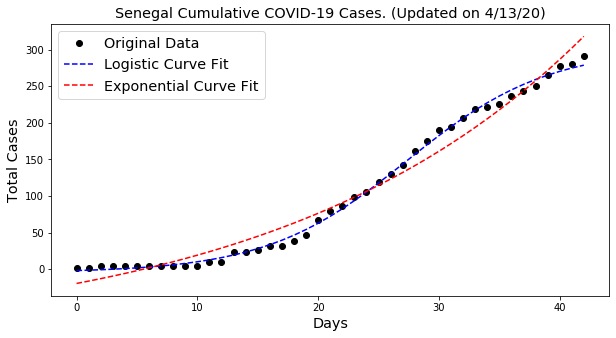



Kosovo

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 283
	Confirmed cases on 4/6/20 	 145
	Ratio: 1.95
	Weekly increase: 95.2 %
	Daily increase: 10.0 % per day
	Doubling Time (represents recent growth): 7.3 days

** Based on Logistic Fit**

	R^2: 0.9637419637474303
	Doubling Time (during middle of growth):  6.36 (± 5.67 ) days
	param:  [4.58877164e+01 2.17838240e-01 7.65426220e+01 5.04078028e+02]

** Based on Exponential Fit **

	R^2: 0.9620716699021548
	Doubling Time (represents overall growth):  5.83 (± 2.19 ) days
	param:  [29.92658055  0.11889992 50.18990586]


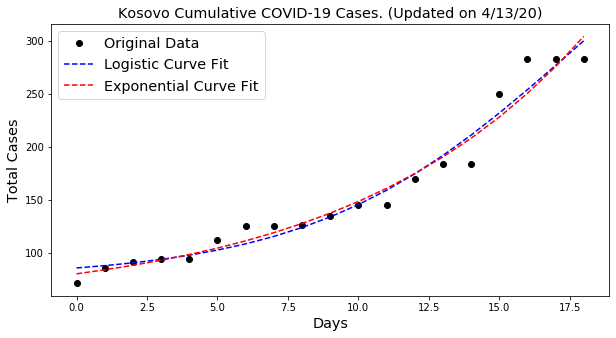



Montenegro

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 274
	Confirmed cases on 4/6/20 	 233
	Ratio: 1.18
	Weekly increase: 17.6 %
	Daily increase: 2.3 % per day
	Doubling Time (represents recent growth): 29.9 days

** Based on Logistic Fit**

	R^2: 0.9908527884364724
	Doubling Time (during middle of growth):  6.16 (± 1.31 ) days
	param:  [ 3.26397235e+01  2.24950698e-01 -3.57729052e+00  3.00035194e+02]

** Based on Exponential Fit **

	R^2: 0.9571594603728492
	Doubling Time (represents overall growth):  13.11 (± 6.09 ) days
	param:  [ 1.00000000e+02  5.28515736e-02 -9.47981335e+01]


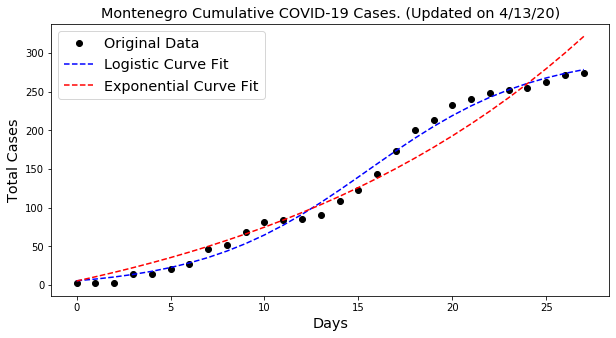



Georgia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 272
	Confirmed cases on 4/6/20 	 188
	Ratio: 1.45
	Weekly increase: 44.7 %
	Daily increase: 5.4 % per day
	Doubling Time (represents recent growth): 13.1 days

** Based on Logistic Fit**

	R^2: 0.9974726484733113
	Doubling Time (during middle of growth):  15.0 (± 1.89 ) days
	param:  [ 9.05559855e+01  9.24172290e-02 -6.38276028e+00  6.02620591e+02]

** Based on Exponential Fit **

	R^2: 0.9960241786849227
	Doubling Time (represents overall growth):  11.39 (± 0.67 ) days
	param:  [ 17.3891173    0.06086925 -21.85604758]


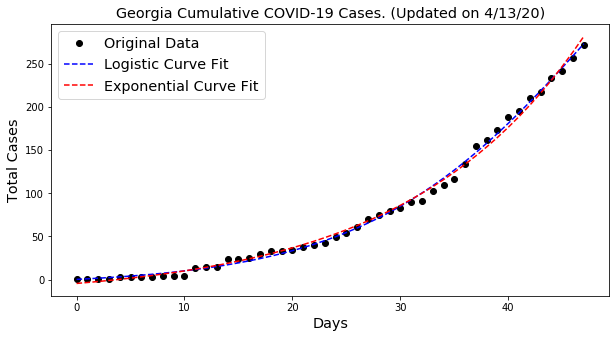



Vietnam

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 265
	Confirmed cases on 4/6/20 	 245
	Ratio: 1.08
	Weekly increase: 8.2 %
	Daily increase: 1.1 % per day
	Doubling Time (represents recent growth): 61.8 days

** Based on Logistic Fit**

	R^2: 0.9974704169273428
	Doubling Time (during middle of growth):  8.24 (± 0.43 ) days
	param:  [3.25267763e+04 1.68252558e-01 1.02360196e+01 2.75865861e+02]

** Based on Exponential Fit **

	R^2: 0.9531482381219032
	Doubling Time (represents overall growth):  15.62 (± 2.11 ) days
	param:  [  9.21191537   0.04436163 -16.75119514]


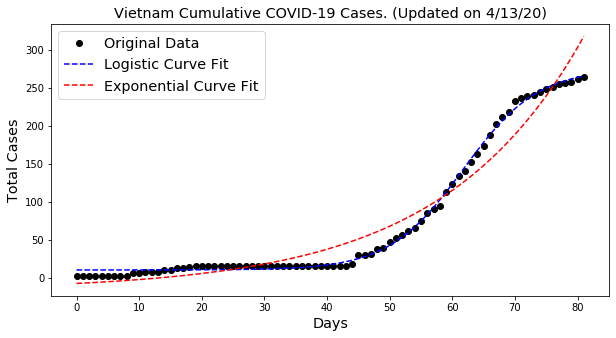



Congo (Kinshasa)

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 235
	Confirmed cases on 4/6/20 	 161
	Ratio: 1.46
	Weekly increase: 46.0 %
	Daily increase: 5.6 % per day
	Doubling Time (represents recent growth): 12.8 days

** Based on Logistic Fit**

	R^2: 0.9933588608902993
	Doubling Time (during middle of growth):  9.12 (± 1.8 ) days
	param:  [ 3.94139081e+01  1.51928197e-01 -1.04102479e+01  3.00053213e+02]

** Based on Exponential Fit **

	R^2: 0.985856572897735
	Doubling Time (represents overall growth):  14.25 (± 3.0 ) days
	param:  [ 6.67437790e+01  4.86458037e-02 -8.01621827e+01]


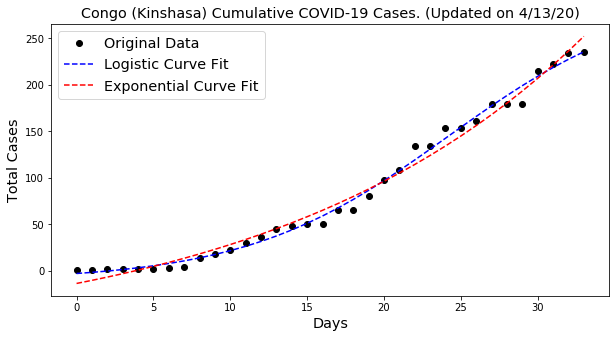



Sri Lanka

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 217
	Confirmed cases on 4/6/20 	 178
	Ratio: 1.22
	Weekly increase: 21.9 %
	Daily increase: 2.9 % per day
	Doubling Time (represents recent growth): 24.5 days

** Based on Logistic Fit**

	R^2: 0.9892972539499146
	Doubling Time (during middle of growth):  8.75 (± 0.97 ) days
	param:  [ 1.20637510e+04  1.58370102e-01 -1.70592308e+00  2.14091816e+02]

** Based on Exponential Fit **

	R^2: 0.9513022445936827
	Doubling Time (represents overall growth):  13.58 (± 1.83 ) days
	param:  [  5.14256401   0.0510413  -16.71519242]


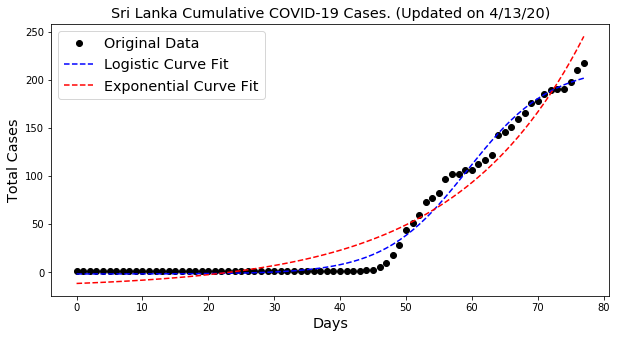



Kenya

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 208
	Confirmed cases on 4/6/20 	 158
	Ratio: 1.32
	Weekly increase: 31.6 %
	Daily increase: 4.0 % per day
	Doubling Time (represents recent growth): 17.6 days

** Based on Logistic Fit**

	R^2: 0.9954198990288495
	Doubling Time (during middle of growth):  4.72 (± 0.56 ) days
	param:  [4.17879193e+02 2.93454765e-01 3.88044863e+00 2.12244539e+02]

** Based on Exponential Fit **

	R^2: 0.9623000654211201
	Doubling Time (represents overall growth):  12.5 (± 4.23 ) days
	param:  [ 5.38830888e+01  5.54328869e-02 -6.86587364e+01]


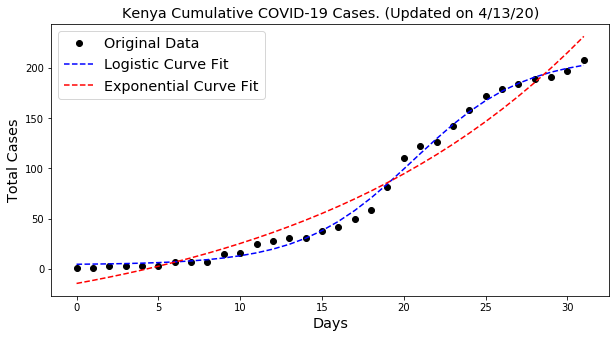



Venezuela

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 189
	Confirmed cases on 4/6/20 	 165
	Ratio: 1.15
	Weekly increase: 14.5 %
	Daily increase: 2.0 % per day
	Doubling Time (represents recent growth): 35.7 days

** Based on Logistic Fit**

	R^2: 0.9955152134144918
	Doubling Time (during middle of growth):  11.9 (± 3.09 ) days
	param:  [ 1.94464490e+00  1.16463162e-01 -9.82598877e+01  1.98267238e+02]

 exponential R^2  0.8998043253285744


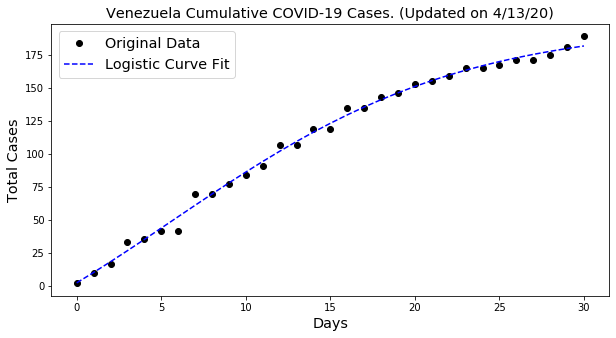



Guatemala

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 156
	Confirmed cases on 4/6/20 	 70
	Ratio: 2.23
	Weekly increase: 122.9 %
	Daily increase: 12.1 % per day
	Doubling Time (represents recent growth): 6.1 days

** Based on Logistic Fit**

	R^2: 0.9871496682266174
	Doubling Time (during middle of growth):  12.19 (± 3.88 ) days
	param:  [7.95373844e+07 1.13736924e-01 9.09243438e-01 4.25794562e+08]

** Based on Exponential Fit **

	R^2: 0.9871496699595886
	Doubling Time (represents overall growth):  6.09 (± 0.73 ) days
	param:  [5.35339904 0.11373686 0.90922599]


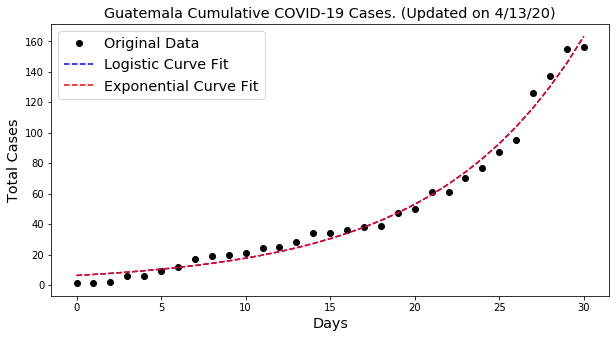



Paraguay

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 147
	Confirmed cases on 4/6/20 	 113
	Ratio: 1.3
	Weekly increase: 30.1 %
	Daily increase: 3.8 % per day
	Doubling Time (represents recent growth): 18.4 days

** Based on Logistic Fit**

	R^2: 0.9959382046434256
	Doubling Time (during middle of growth):  8.58 (± 1.1 ) days
	param:  [ 5.52633160e+01  1.61520157e-01 -2.33198943e+00  1.65300813e+02]

** Based on Exponential Fit **

	R^2: 0.9831540915675945
	Doubling Time (represents overall growth):  16.25 (± 3.72 ) days
	param:  [ 4.44210567e+01  4.26479169e-02 -5.19512161e+01]


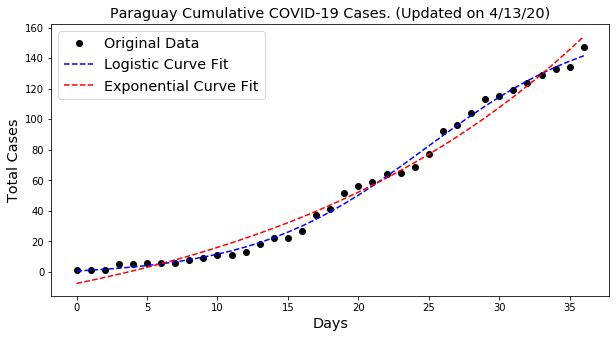



El Salvador

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 137
	Confirmed cases on 4/6/20 	 69
	Ratio: 1.99
	Weekly increase: 98.6 %
	Daily increase: 10.3 % per day
	Doubling Time (represents recent growth): 7.1 days

** Based on Logistic Fit**

	R^2: 0.9964101177492789
	Doubling Time (during middle of growth):  7.73 (± 1.49 ) days
	param:  [ 4.55916918e+01  1.79400894e-01 -3.96379386e+00  2.10016919e+02]

** Based on Exponential Fit **

	R^2: 0.9923474245637078
	Doubling Time (represents overall growth):  8.53 (± 1.24 ) days
	param:  [ 22.18075554   0.08128475 -25.88264548]


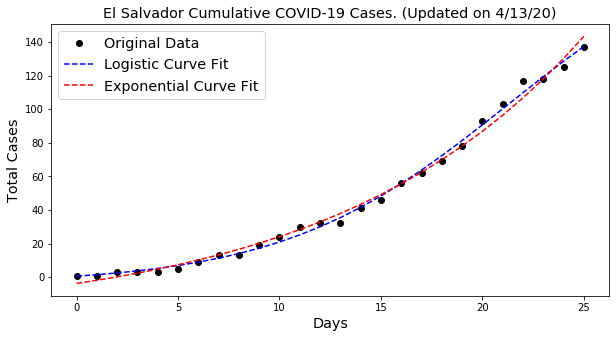



Brunei

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 136
	Confirmed cases on 4/6/20 	 135
	Ratio: 1.01
	Weekly increase: 0.7 %
	Daily increase: 0.1 % per day
	Doubling Time (represents recent growth): 657.4 days

** Based on Logistic Fit**

	R^2: 0.9933442060209364
	Doubling Time (during middle of growth):  8.81 (± 1.62 ) days
	param:  [  2.37258128   0.15738243 -61.26199602 140.52398703]

 exponential R^2  0.7918964434561169


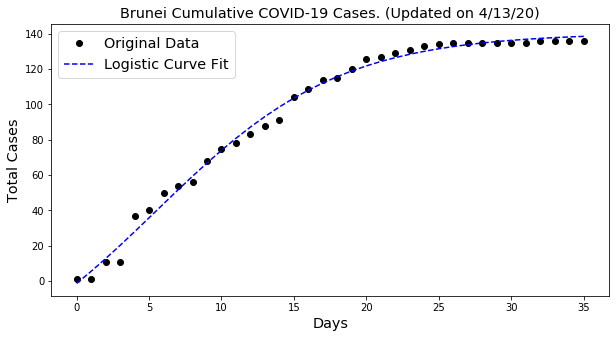



Rwanda

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 127
	Confirmed cases on 4/6/20 	 105
	Ratio: 1.21
	Weekly increase: 21.0 %
	Daily increase: 2.8 % per day
	Doubling Time (represents recent growth): 25.5 days

** Based on Logistic Fit**

	R^2: 0.9944785357983646
	Doubling Time (during middle of growth):  9.17 (± 1.86 ) days
	param:  [  8.28905026   0.15117062 -18.77702291 136.931941  ]

** Based on Exponential Fit **

	R^2: 0.9660225454216907
	Doubling Time (represents overall growth):  23.91 (± 14.79 ) days
	param:  [ 1.00000000e+02  2.89949230e-02 -9.64741052e+01]


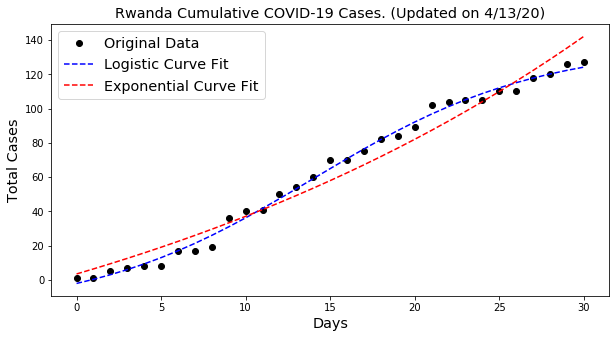



Mali

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 123
	Confirmed cases on 4/6/20 	 47
	Ratio: 2.62
	Weekly increase: 161.7 %
	Daily increase: 14.7 % per day
	Doubling Time (represents recent growth): 5.0 days

** Based on Logistic Fit**

	R^2: 0.983486015582943
	Doubling Time (during middle of growth):  13.26 (± nan ) days
	param:  [ 3.91161114e+07  1.04526055e-01 -9.01365835e+00  6.78661333e+08]

** Based on Exponential Fit **

	R^2: 0.9834860168742107
	Doubling Time (represents overall growth):  6.63 (± 1.68 ) days
	param:  [17.34972163  0.10452657 -9.01339766]


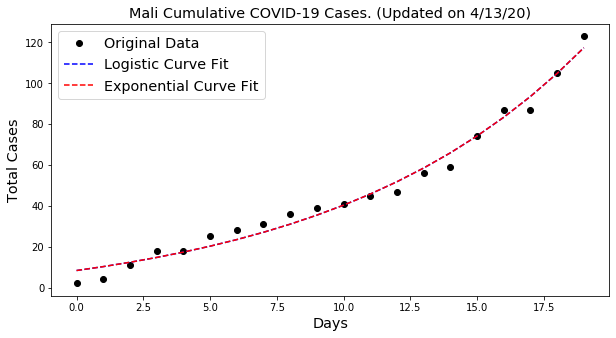



Cambodia

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 122
	Confirmed cases on 4/6/20 	 114
	Ratio: 1.07
	Weekly increase: 7.0 %
	Daily increase: 1.0 % per day
	Doubling Time (represents recent growth): 71.5 days

** Based on Logistic Fit**

	R^2: 0.9947110894473518
	Doubling Time (during middle of growth):  3.75 (± 0.35 ) days
	param:  [4.08933330e+08 3.69263078e-01 6.37570174e-01 1.14843870e+02]

 exponential R^2  0.8792025566017808


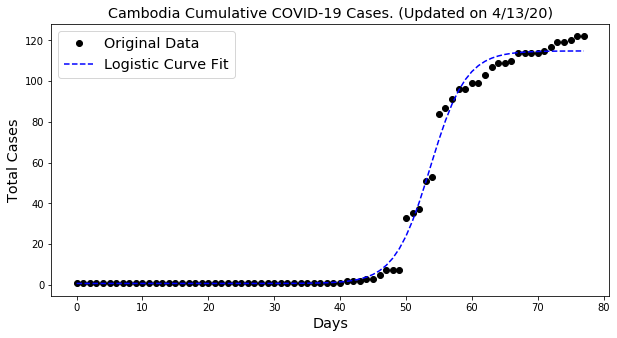



Trinidad and Tobago

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 113
	Confirmed cases on 4/6/20 	 105
	Ratio: 1.08
	Weekly increase: 7.6 %
	Daily increase: 1.1 % per day
	Doubling Time (represents recent growth): 66.1 days

** Based on Logistic Fit**

	R^2: 0.978003090695682
	Doubling Time (during middle of growth):  7.92 (± 2.88 ) days
	param:  [  4.2754903    0.17507926 -33.30030678 115.37499482]

 exponential R^2  0.8717239589037717


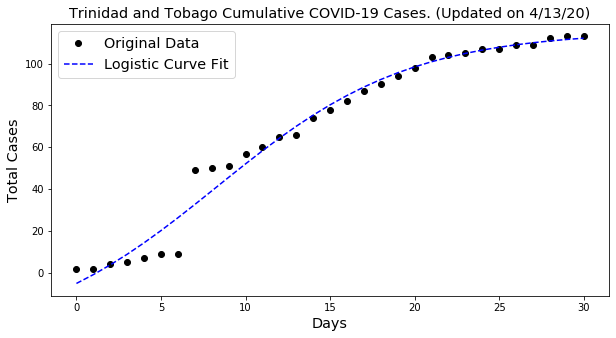



Madagascar

** Based on Most Recent Week of Data **

	Confirmed cases on 4/13/20 	 106
	Confirmed cases on 4/6/20 	 82
	Ratio: 1.29
	Weekly increase: 29.3 %
	Daily increase: 3.7 % per day
	Doubling Time (represents recent growth): 18.9 days

** Based on Logistic Fit**

	R^2: 0.9924870101262449
	Doubling Time (during middle of growth):  8.39 (± 2.62 ) days
	param:  [  6.64618669   0.16528762 -17.15135513 121.46204185]

** Based on Exponential Fit **

	R^2: 0.973001439411849
	Doubling Time (represents overall growth):  21.96 (± 15.41 ) days
	param:  [ 1.00000000e+02  3.15679382e-02 -9.53890583e+01]


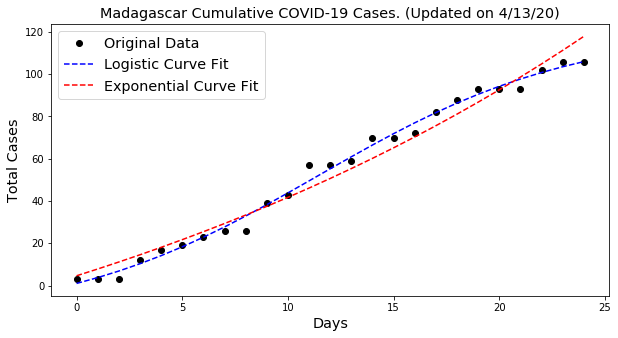

In [6]:
topcountries = cases.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
print('\n')

cnames = topcountries.values

for c in cnames:
    print(c)
    a = plotCases(df, 'Country/Region', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for Global COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


     Inferred Doubling Time  95%CI  Recent Doubling Time
0                       7.2    0.2                  10.6
1                       7.3    0.2                  22.2
2                       9.6    0.4                  26.2
3                       8.1    0.5                  14.6
4                       7.8    0.2                  21.1
5                       8.1    0.3                   9.0
6                       6.6    0.4                 734.3
7                      13.4    1.1                  25.3
8                       7.8    0.6                   6.9
9                       8.1    0.4                  12.6
10                      9.6    0.7                  14.1
11                      8.0    0.5                  28.4
12                      7.2    0.2                 

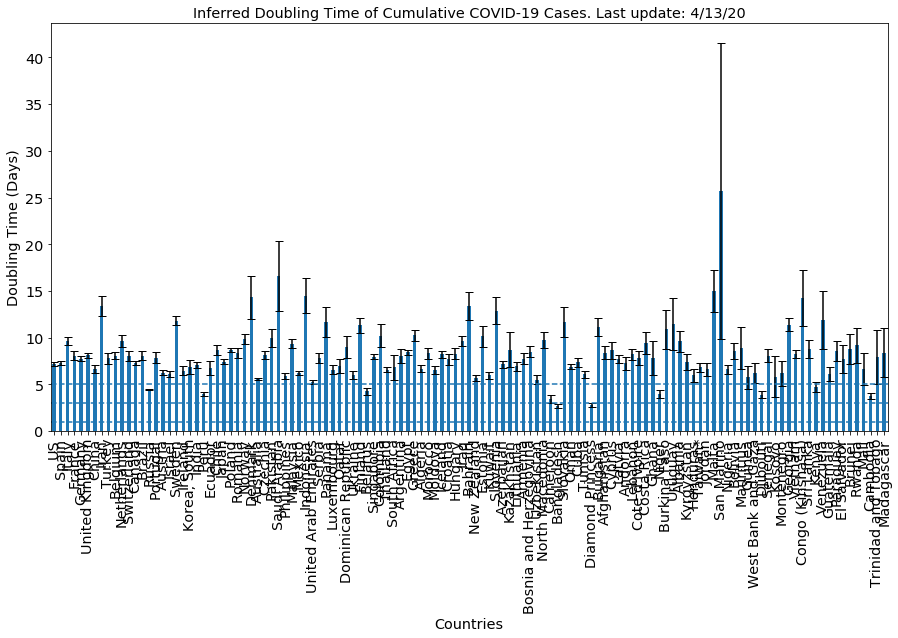

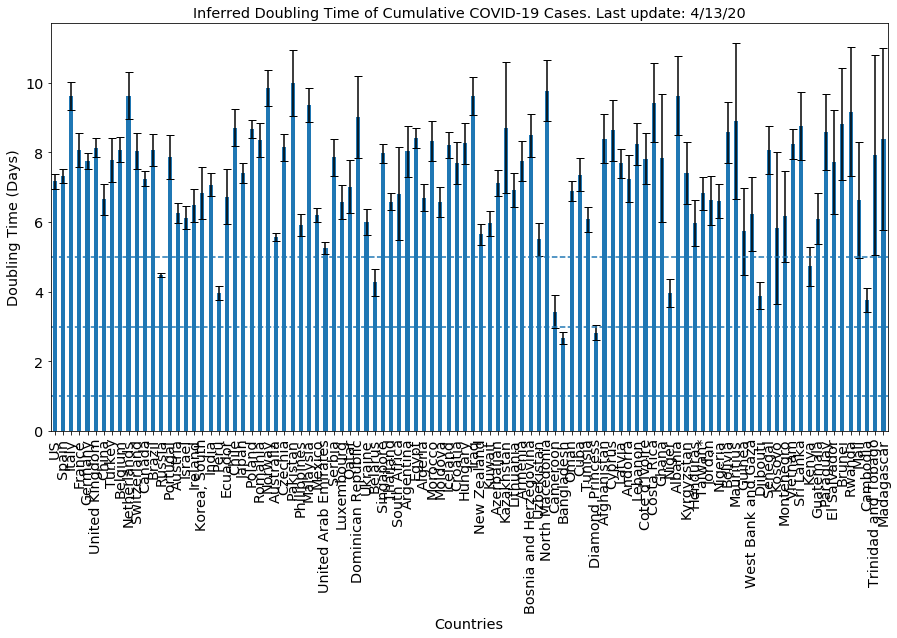

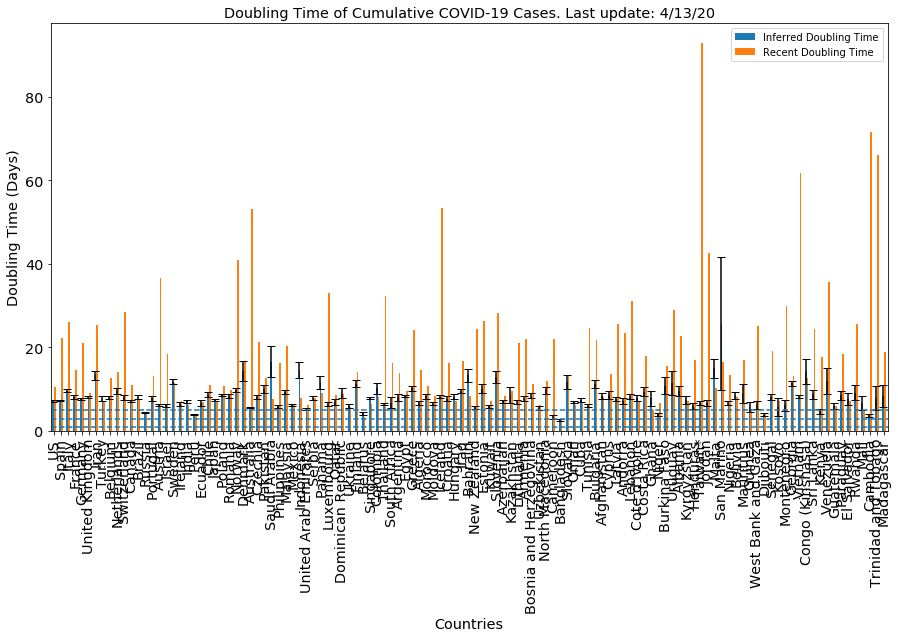

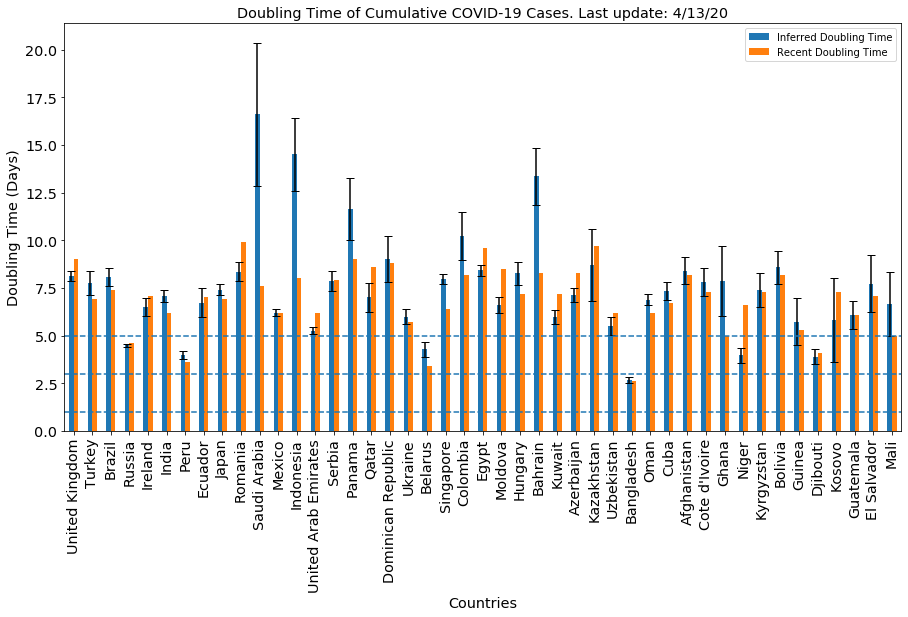

In [7]:
d = {'Countries': countries, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')

print(pd.DataFrame(data=d).iloc[:,[1,2,3]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 10]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=countries
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 10]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()